In [67]:
## import libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import skimage 

#torch 
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import MNIST 

#import pca 
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse


In [2]:
batch_size = 256
epochs =10
learning_rate  = 0.001


In [3]:
#Download the dataset 
train_dataset = MNIST(root='./data', 
                    train=True, 
                    transform=transforms.ToTensor(),  
                    download=True)

test_dataset = MNIST(root='./data', 
                    train=False, 
                    transform=transforms.ToTensor())

In [4]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


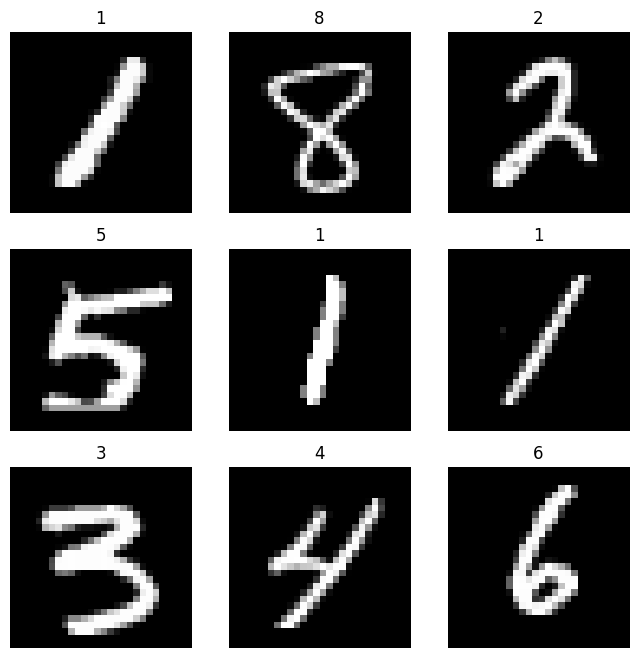

In [5]:
#code taken from the official documentation 
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
train_images = train_dataset.data
train_labels = train_dataset.targets
print(f"Training image shape:{train_images.shape}")
print(f"Training Targets shape:{train_labels.shape}")


val_images = test_dataset.data
val_labels = test_dataset.targets
print(f"validation image shape:{val_images.shape}")
print(f"validation Targets shape:{val_labels.shape}")

Training image shape:torch.Size([60000, 28, 28])
Training Targets shape:torch.Size([60000])
validation image shape:torch.Size([10000, 28, 28])
validation Targets shape:torch.Size([10000])


## Q1

In [7]:
##PCA and Autoencoder

In [8]:
#first 30 eigenvectors corresponding to top 30 eigenvalues
pca_comps_n =30
print('PCA with', pca_comps_n ,'principal components')
train_data = np.asarray(train_images)/255
test_data = np.asarray(val_images)/255
total_data =  np.concatenate((train_data,test_data))
PCA_data = total_data.reshape(-1,28*28)
# PCA_data = train_data.reshape(-1,28*28)

pca1 = PCA(n_components = pca_comps_n) 
pca1.fit(PCA_data)
train_pca = pca1.transform(PCA_data)
reconstructed_data = pca1.inverse_transform(train_pca)
PCA_error = mse(PCA_data,reconstructed_data)
print('Reconstruction error made by PCA: ',PCA_error)

PCA with 30 principal components
Reconstruction error made by PCA:  0.01805640184447451


In [9]:
#0-5,1-0,2-4,3-1,4-9,5-2,7-3,13-6,15-7,17-8
keys = [1,3,5,7,2,0,13,15,17,4]

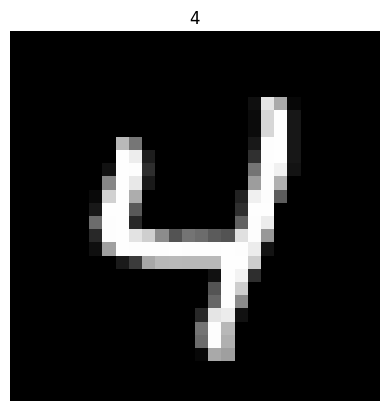

In [10]:
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

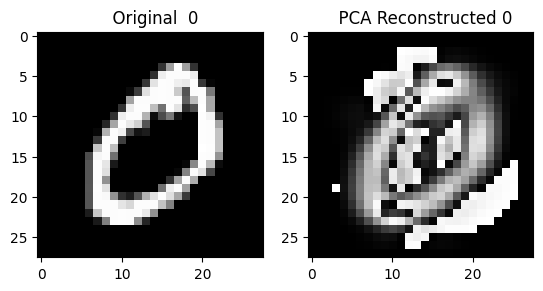

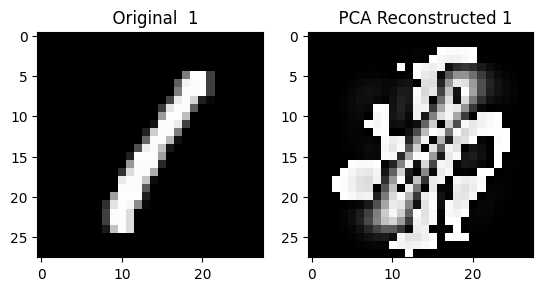

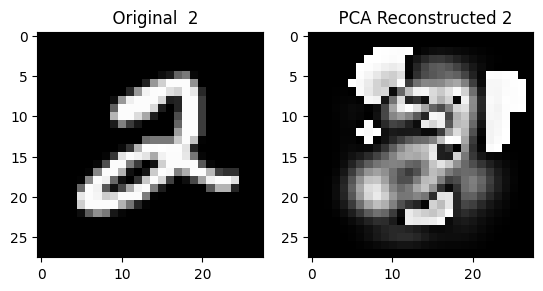

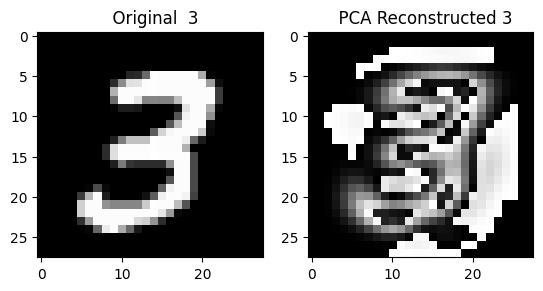

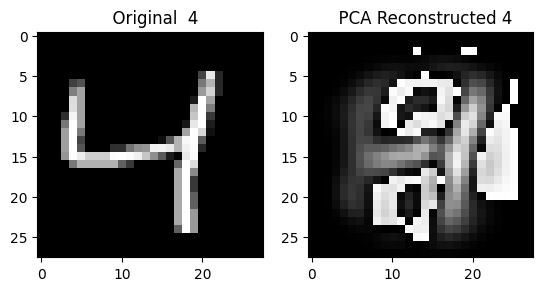

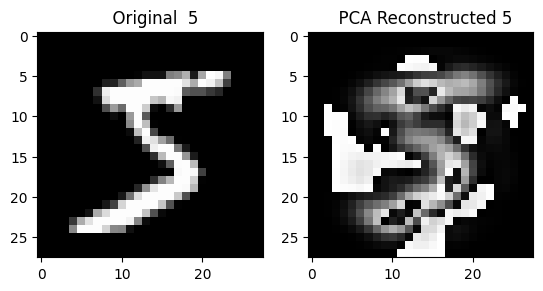

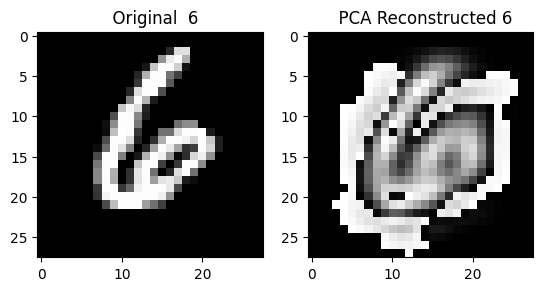

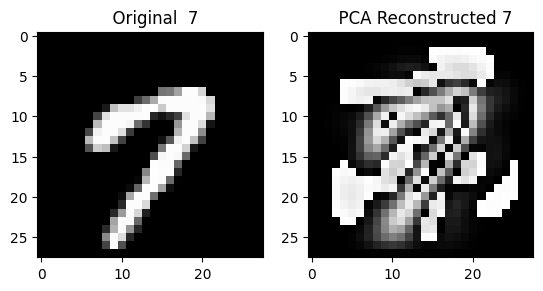

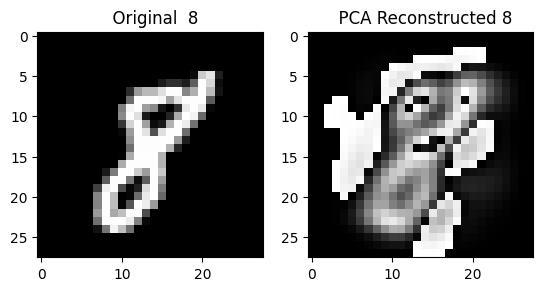

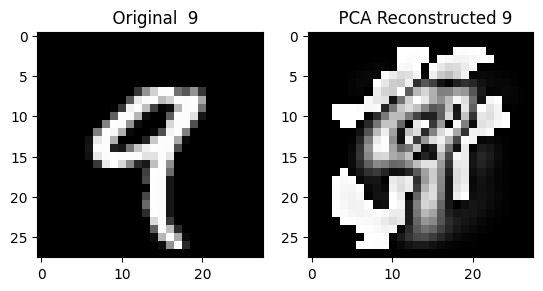

In [12]:
from numpy import uint8

for t,j in zip(range(10),keys):
    input_image =  np.asarray(255*PCA_data[j],dtype=uint8).reshape(28,28)
    reconstruct_image = np.asarray(255*reconstructed_data[j],dtype=uint8).reshape(28,28)
    plt.subplot(1,2,1)
    
    plt.imshow(input_image,'gray')
    plt.title('  Original  '+str(t))
    plt.subplot(1,2,2)
    
    plt.imshow(reconstruct_image,'gray')
    plt.title('  PCA Reconstructed '+str(t))
    plt.show()

In [13]:
from torch import flatten

In [14]:
class AE1(nn.Module):
  def __init__(self):
    super(AE1, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,30),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(30,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,784),
        nn.ReLU())
    
  def forward(self,x):
    x = flatten(x,1)
    encoded=self.encoder(x.float())
    reconstructed =self.decoder(encoded)
    return reconstructed    , encoded

In [15]:
# Loss function
lossfn = nn.MSELoss()

In [16]:
from torch import flatten
def train(model,device,train_dataloader,optimizer,lossfn,lambda_reg=0,sparse=False,denoise=False,noise_val=0.3, q5_flag = False):
    model.train() #setting the model in training mode
    #initializing the total training loss to 0
    train_loss    = 0
    #loop over the training set
    for batch_idx, (data,label) in enumerate(train_dataloader):  # (data,label): Training data for that batch
        if denoise==True:
            img = data.clone()
            data = add_noise(img,noise_val)
            data = data.to(device) 
        else:
            (data,label) = (data.to(device),label.to(device))  #sending the data to the device we've chosen
            
        reconstruction,encoded = model(data) #our reconstruction
        if q5_flag==True:
            loss = lossfn(reconstruction,data) #loss 
        else:
            loss = lossfn(reconstruction,flatten(data,1)) #loss 
        if sparse==True:
            loss += lambda_reg*torch.linalg.norm(encoded,1) 
        optimizer.zero_grad() #zeroing out the gradients before backprop
        loss.backward()       #backprop from the loss
        optimizer.step()      #updating the weights
        train_loss    += loss/len(train_dataloader)
    return train_loss #returning loss

In [17]:
def test(model,device,test_dataloader,lossfn,lambda_reg=0,sparse=False,denoise=False,noise_val=0.3, q5_flag = False):
    model.eval() 
    test_loss    = 0
    with torch.no_grad():
        for (data,label) in test_dataloader: # (data,label): Test data for that batch
            if denoise==True:
                img = data.clone()
                data = add_noise(img,noise_val)
                data = data.to(device)
            else:
                (data,label) = (data.to(device),label.to(device))  #sending the data to the device we've chosen
            #perform forward pass and compute the loss
            reconstruction,encoded = model(data) #our prediction
            if q5_flag==True:
                loss = lossfn(reconstruction,data) #loss  
            else:
                 loss = lossfn(reconstruction,flatten(data,1)) #loss 
            if sparse==True:
                loss += lambda_reg*torch.linalg.norm(encoded,1) 
            test_loss    += loss/len(test_dataloader)
    return test_loss #returning loss

In [18]:
def train_test(model,device,train_loader,test_loader,optimizer,lossfn,lambda_reg=0,sparse=False,denoise=False,noise_val=0.3,q5_flag=False): 
    train_losses   = []
    test_losses    = []
    for epoch in range(epochs+1):
        #train the model
        train_loss = train(model,device,train_loader,optimizer,lossfn,lambda_reg,sparse,denoise,noise_val,q5_flag)
        train_losses.append(train_loss.item())
        #test the model
        test_loss = test(model,device,test_loader,lossfn,lambda_reg,sparse,denoise,noise_val,q5_flag)
        test_losses.append(test_loss.item())
    return train_losses, test_losses

In [19]:
def plot_reconstructed_image(model,device,img,model_name,q5_flag=False):
#     img = torch.from_numpy(img)
    with torch.no_grad():
        if q5_flag == False:
            if (device==torch.device("cuda")):
                img = img.view(-1,28,28).cuda().float()
            else:
                img = img.view(-1,28,28).float()
        else:
            if (device==torch.device("cuda")):
                img = img.reshape(1,1,28,28).cuda().float()
            else:
                img = img.reshape(1,1,28,28).float()
        reconstructed_image,encoded = model.forward(img) #as it is a single image we directly run the forward pass
        reconstructed_image=reconstructed_image.detach().cpu().numpy()
        img = img.reshape(28,28).detach().cpu().numpy()
        plt.subplot(1,2,1)
        plt.imshow(img , cmap='gray')
        plt.title('input image')
        plt.subplots_adjust(right=1.5)
        plt.subplot(1,2,2)
        plt.imshow(reconstructed_image.reshape(28,28),cmap ='gray') #our reconstructed image
        plt.title("Reconstructed image using "+ str(model_name))
        plt.show()

In [20]:
def plot_losses(train_losses, test_losses, model_name):
    train_interval = int(len(train_losses)/epochs)
    plt.plot(np.asarray(train_losses)[::train_interval])
    plt.title("MSE train loss using "+ str(model_name))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    test_interval = int(len(test_losses)/epochs)
    plt.plot(np.asarray(test_losses)[::test_interval])
    plt.title("MSE test loss using "+ str(model_name))
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.show()

In [21]:
model_Q1 = AE1().to(device) 
optimizer = torch.optim.Adam(model_Q1.parameters(), lr=learning_rate)
train_losses_AE_Q1 , test_losses_AE_Q1 = train_test(model_Q1,device,train_loader,test_loader,optimizer,lossfn)

In [22]:
'''
0-7
1-2
2-1
3-0
4-4
7-9
8-5
11-6
18-3
84-8
'''

'\n0-7\n1-2\n2-1\n3-0\n4-4\n7-9\n8-5\n11-6\n18-3\n84-8\n'

In [23]:
keys_test=[3,2,1,18,4,8,11,0,84,7]

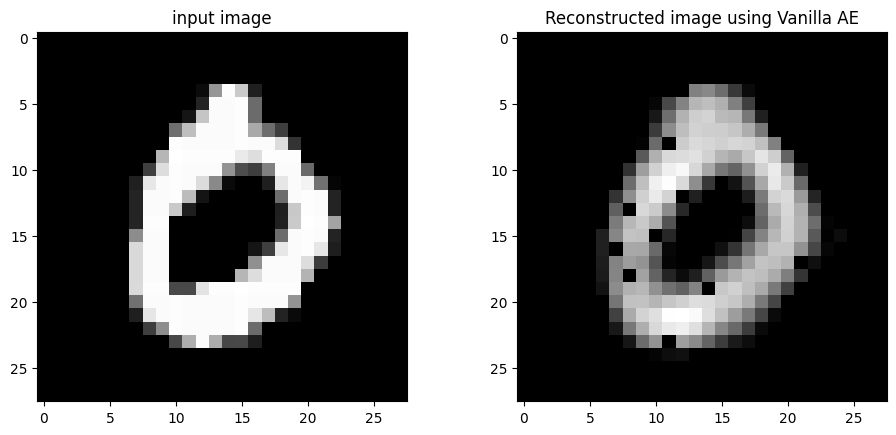

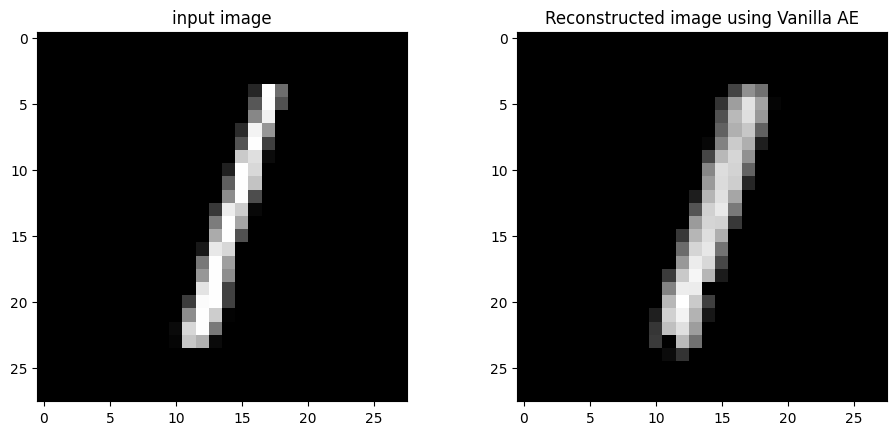

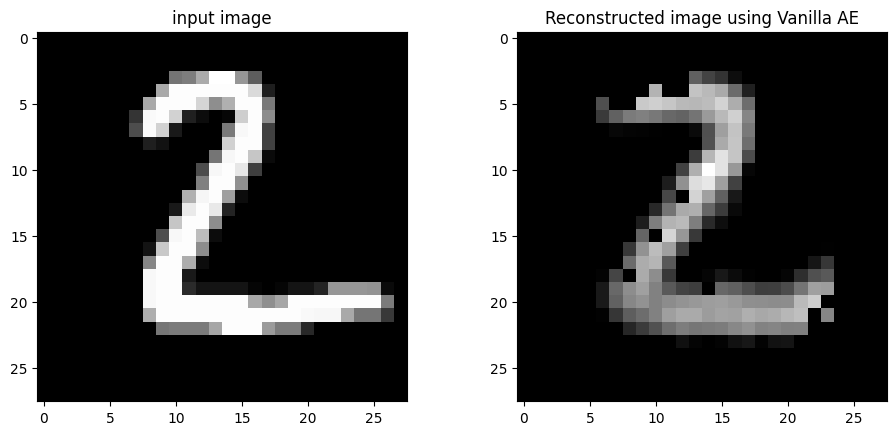

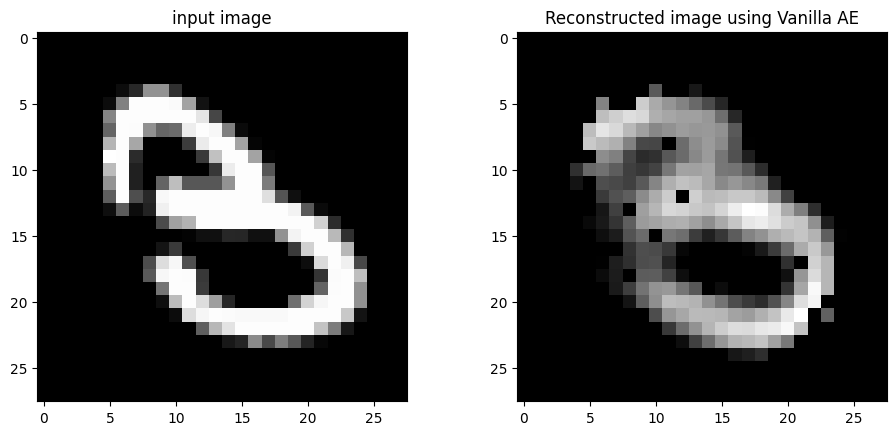

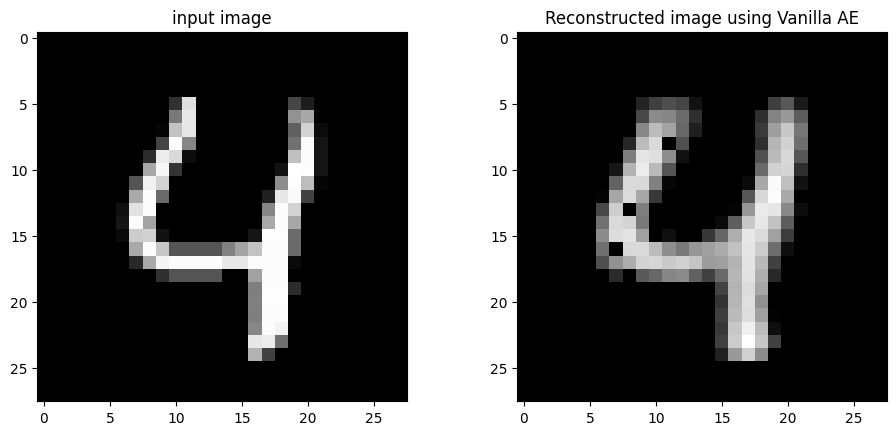

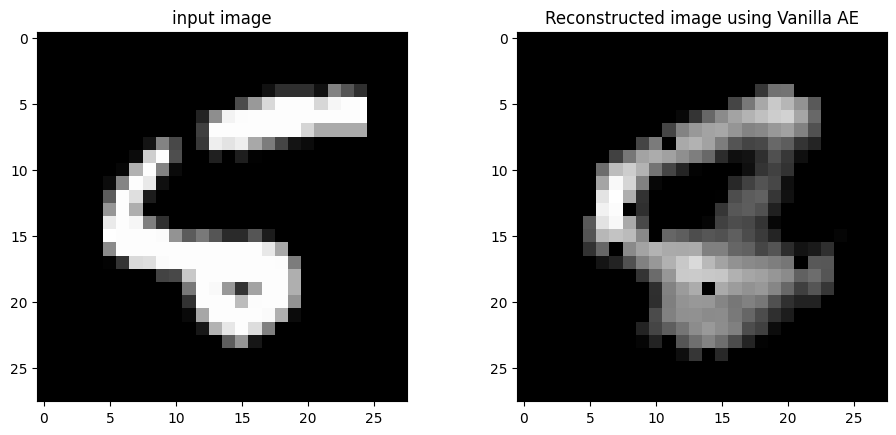

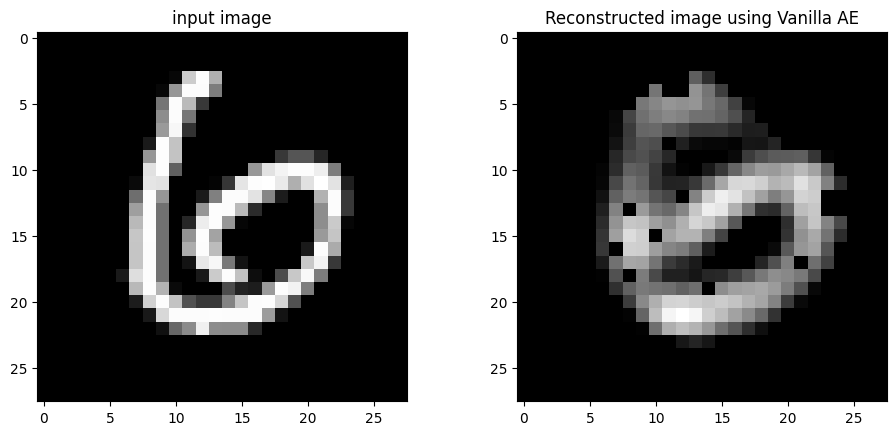

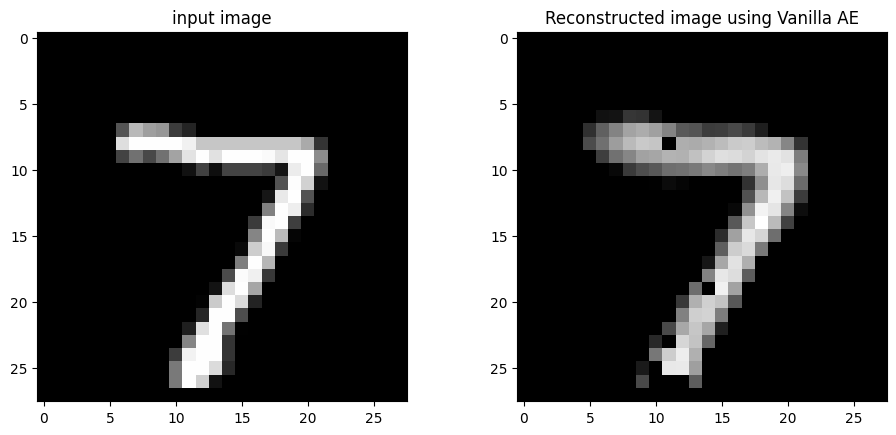

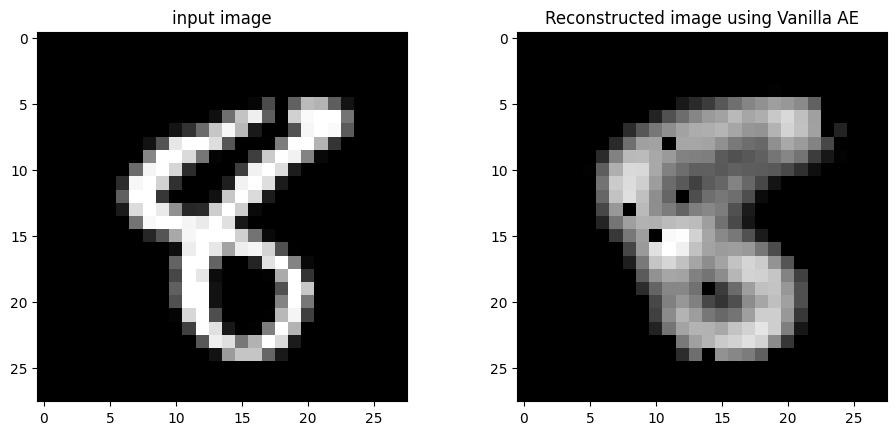

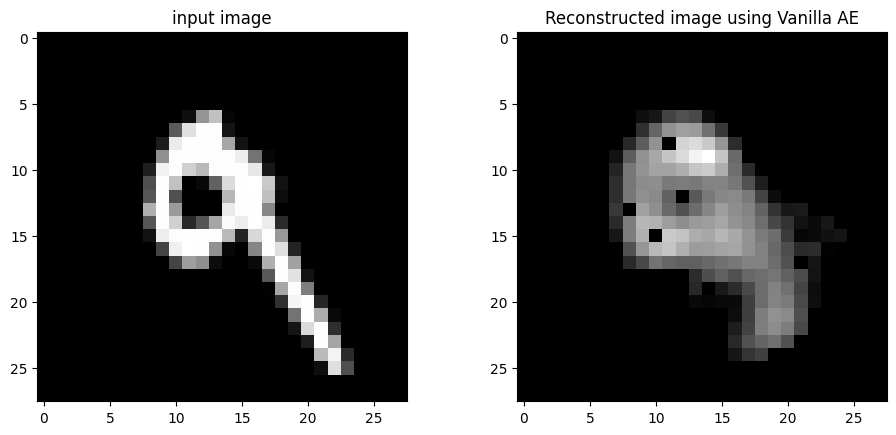

In [24]:
import random
# index = random.randint(0,9999)
for i in keys_test:
    test_image = test_loader.dataset.data[i, :, :].clone()
    plot_reconstructed_image(model_Q1,device,test_image, model_name="Vanilla AE")
# print(type(test_image))

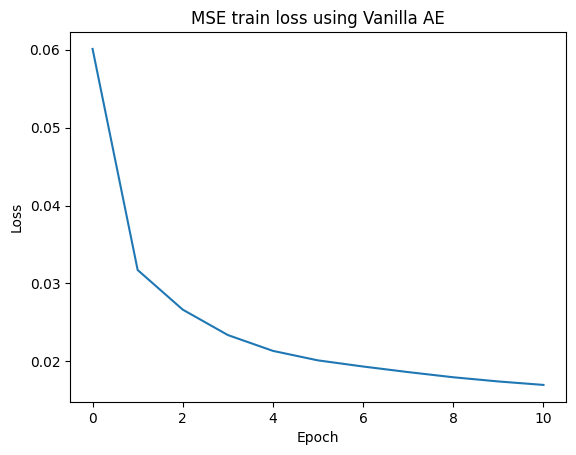

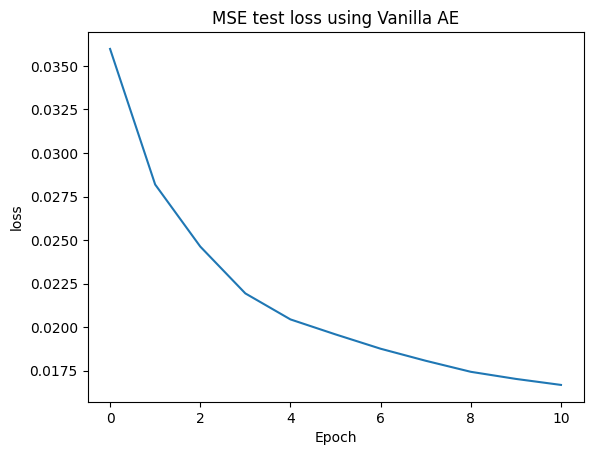

In [25]:
 plot_losses(train_losses_AE_Q1, test_losses_AE_Q1, model_name = "Vanilla AE")

In [26]:
#MSE recomnstruction error for vanilla AE
mse_error = test(model_Q1,device,test_loader,lossfn)
print("MSE Reconstruction error for Vanilla AE is ", mse_error.item())

MSE Reconstruction error for Vanilla AE is  0.016686905175447464


## Q2

In [27]:
class AE_Q2(nn.Module):
  def __init__(self,hidden_layer):
    super(AE_Q2, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(784,hidden_layer),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(hidden_layer,784),
        nn.ReLU())


  def forward(self,x):
    x = flatten(x,1)
    encoded=self.encoder(x.float())
    reconstructed =self.decoder(encoded)
    return reconstructed    , encoded  
 

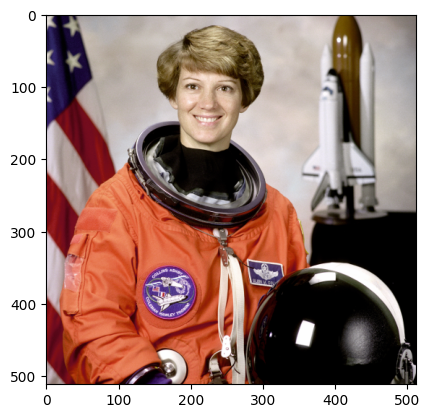

(512, 512, 3)
(512, 512)


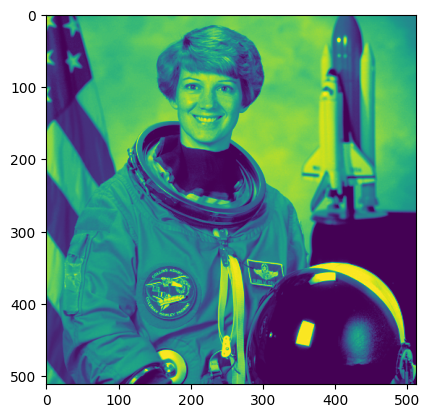

In [28]:
from skimage import data
astronaut = data.astronaut()
plt.imshow(astronaut)
plt.show()
print(astronaut.shape)
from skimage.color import rgb2gray
grayscale_astro = rgb2gray(astronaut)
plt.imshow(grayscale_astro)
print(grayscale_astro.shape)
plt.show()
# flower = cv2.imread("flower.png")
# flower = cv2.cvtColor(flower, cv2.COLOR_BGR2GRAY)
# plt.imshow(flower)

In [29]:
import skimage.transform 
from skimage import img_as_ubyte
grayscale_astro = np.asarray(grayscale_astro)
non_digit_image = torch.from_numpy(img_as_ubyte(skimage.transform.resize(grayscale_astro, (28,28)))) 

In [30]:
X = np.random.normal(loc=128,scale=10,size=(28,28)) #Initializing a 28x28 matrix with gaussian noise 1ith mean = 128, std=10
#converting X to Tensor
if(device==torch.device("cuda")):
    noisy_image = torch.from_numpy(X).reshape(1,1,28,28).cuda().float()
else:
    noisy_image = torch.from_numpy(X).reshape(1,1,28,28).float()

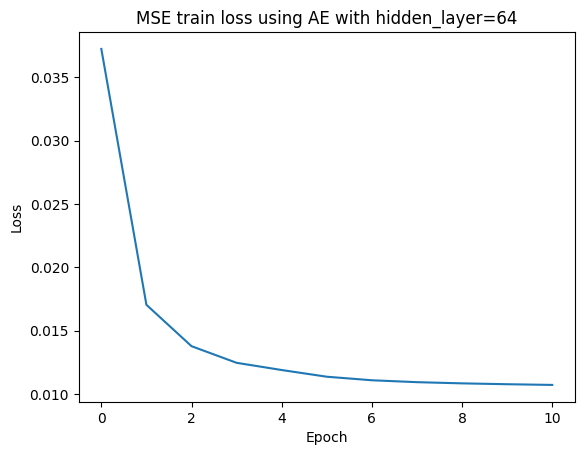

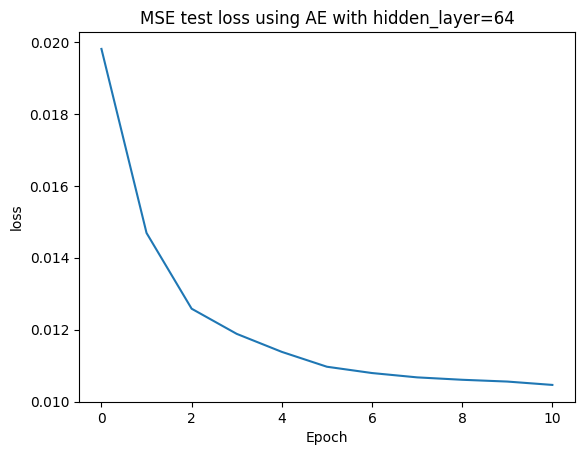

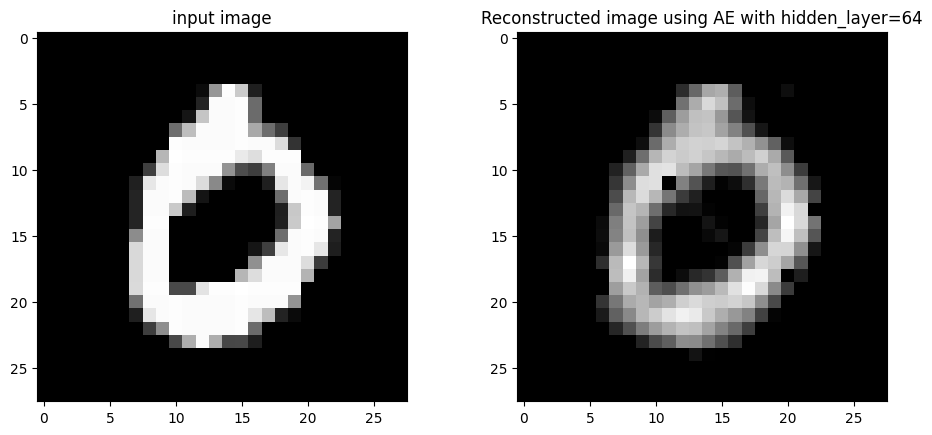

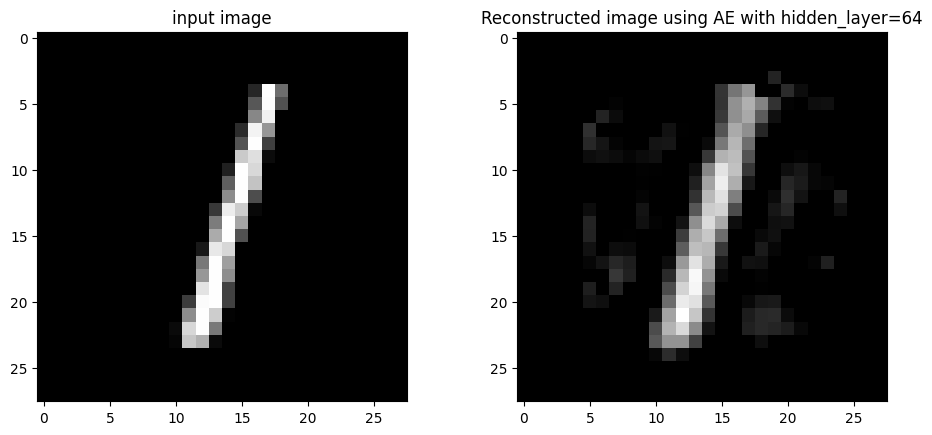

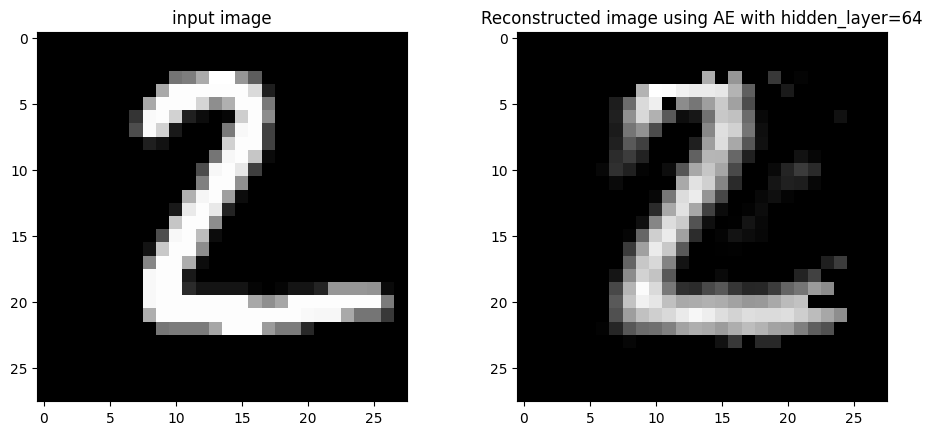

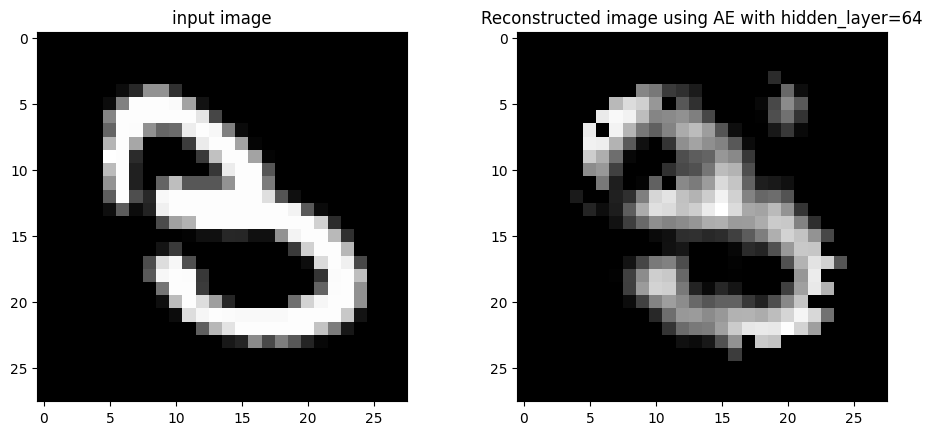

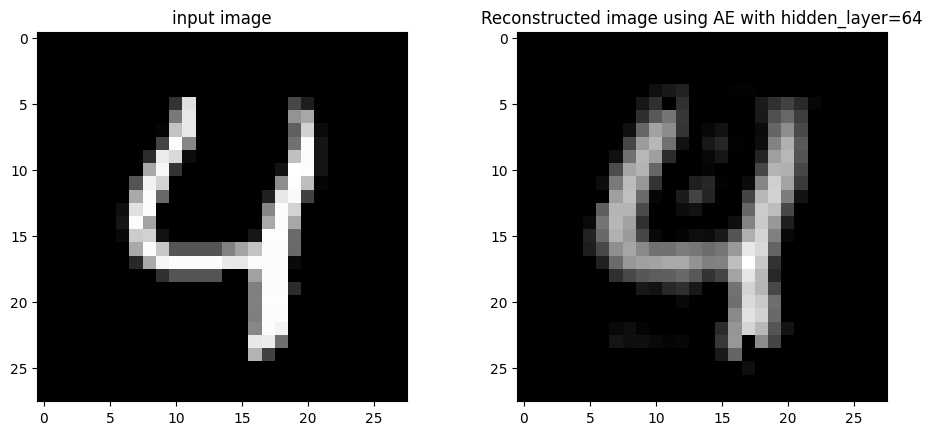

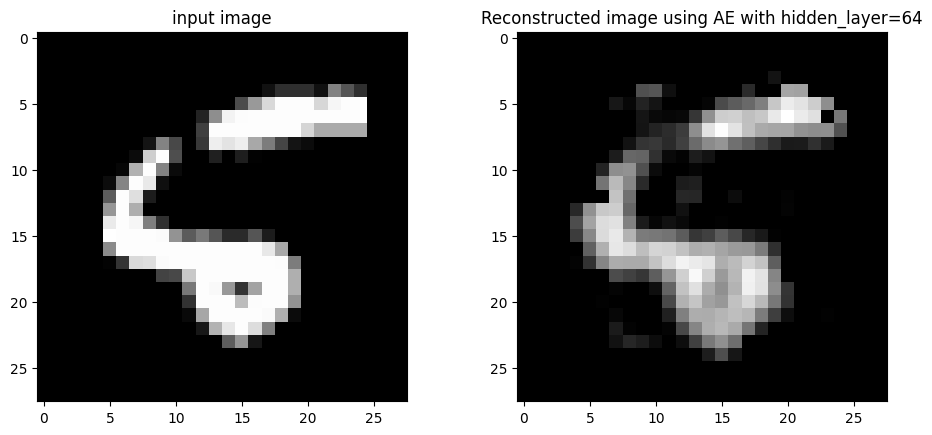

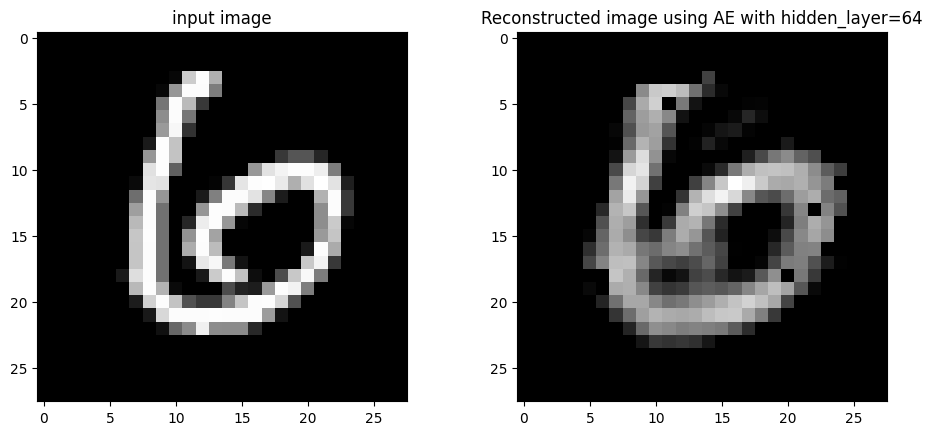

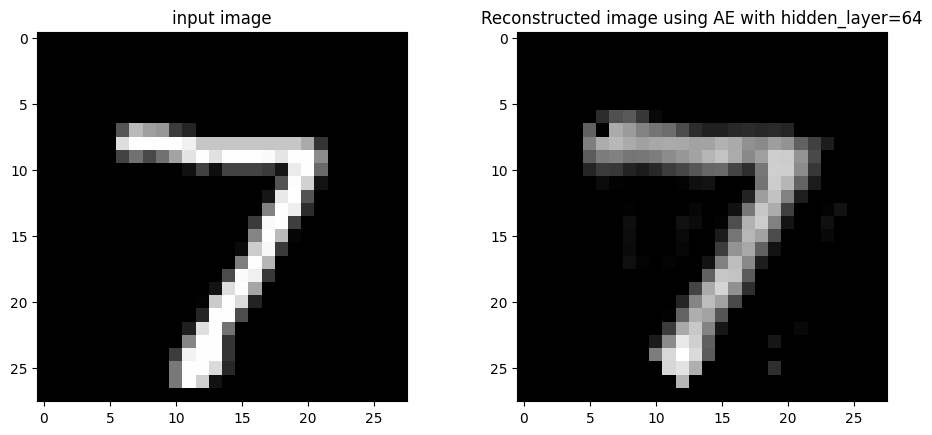

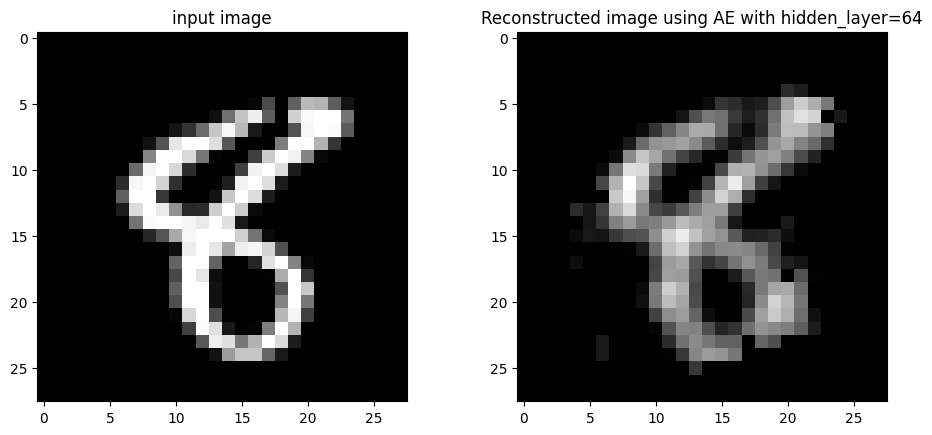

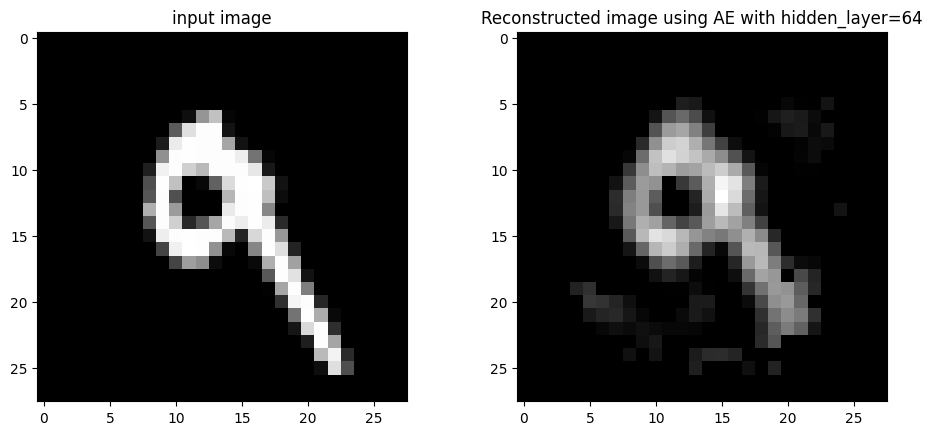

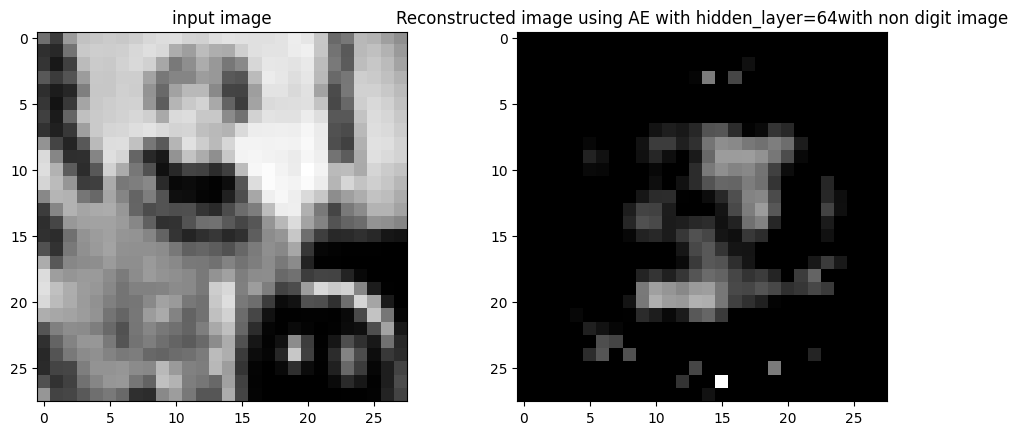

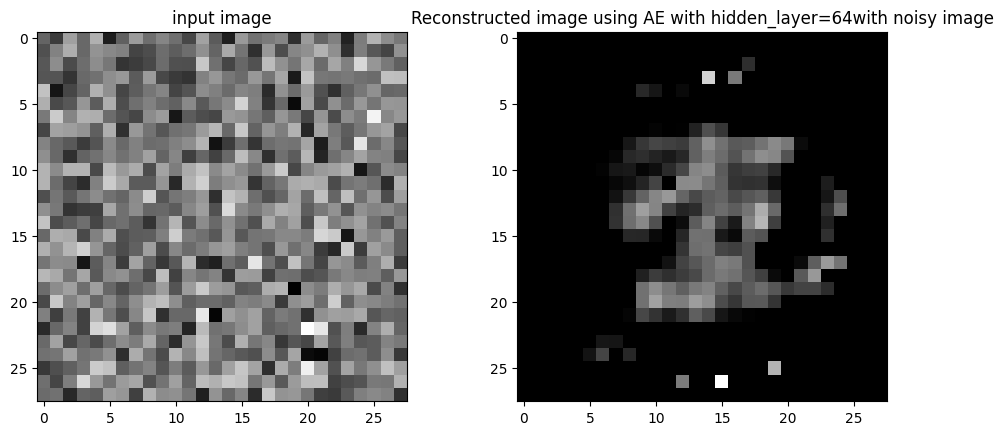

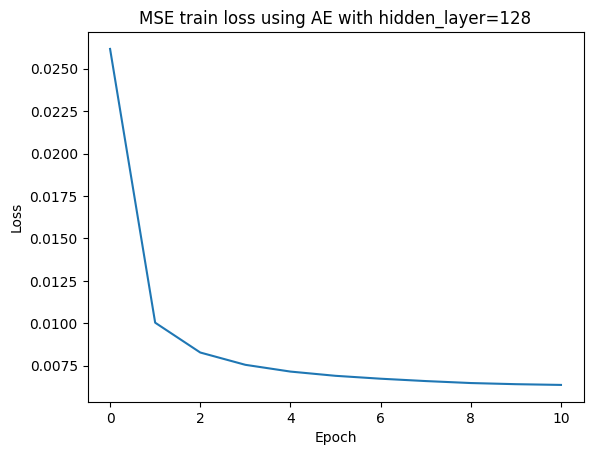

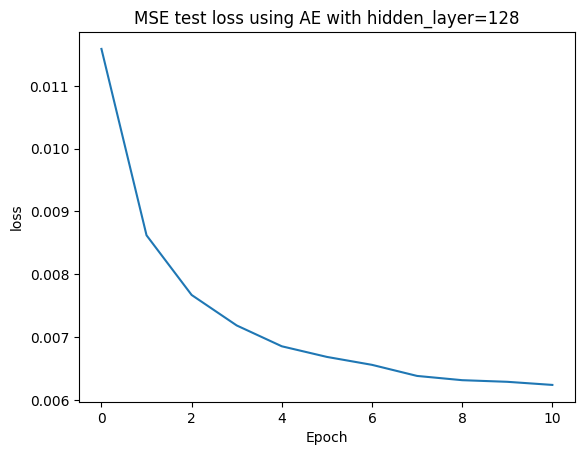

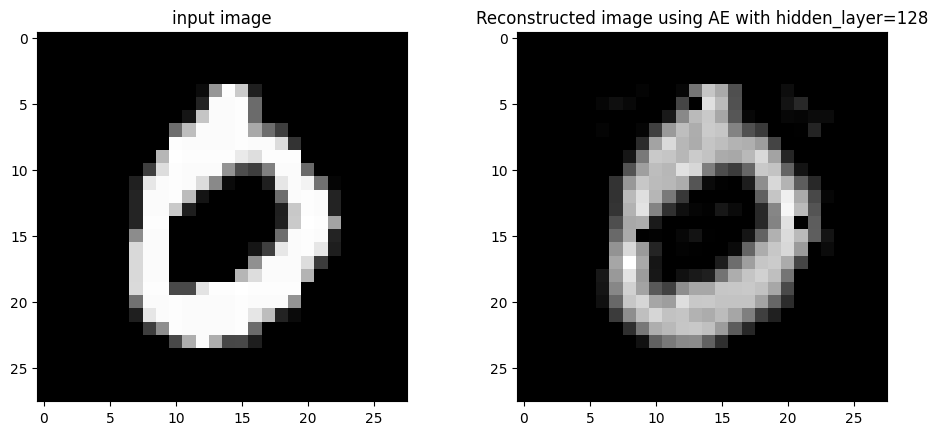

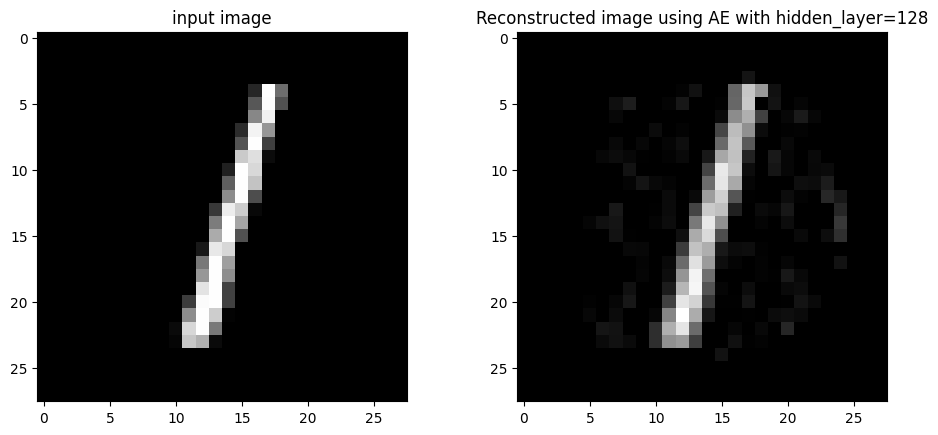

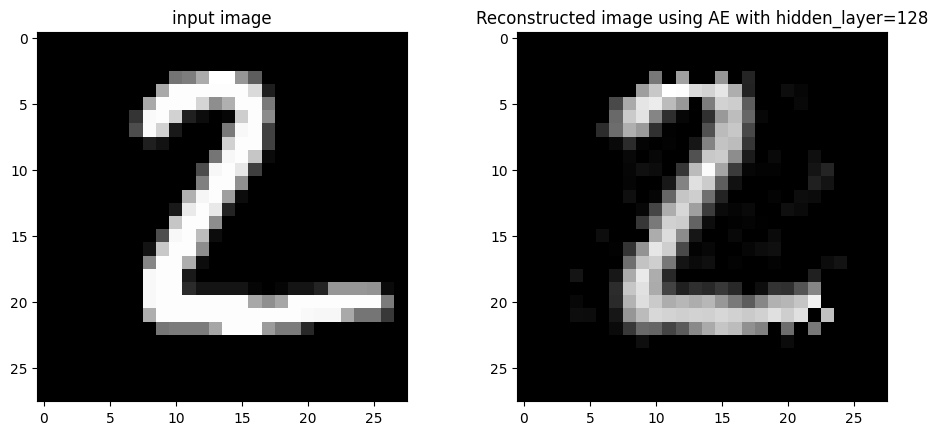

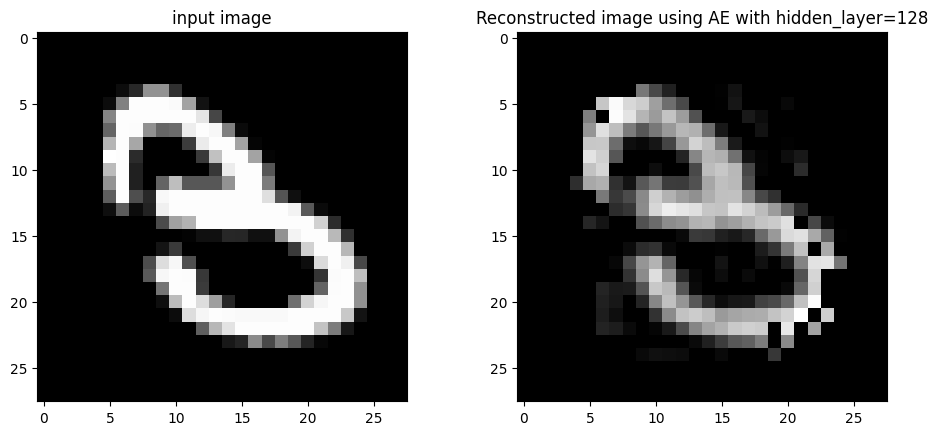

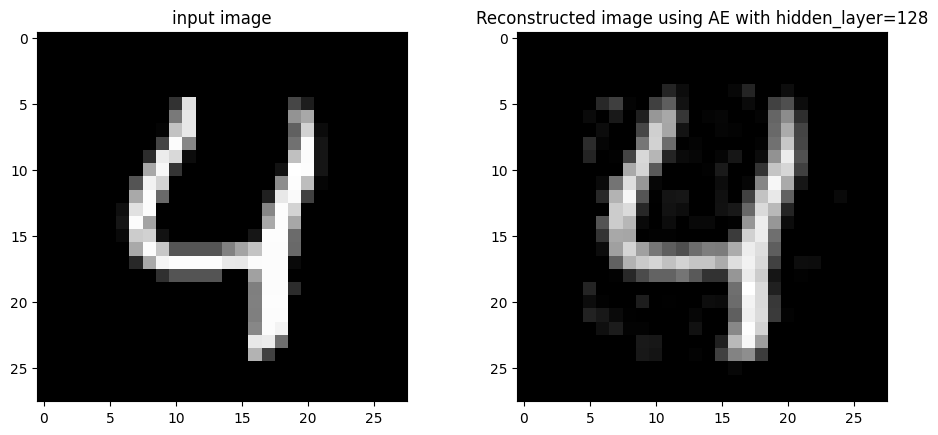

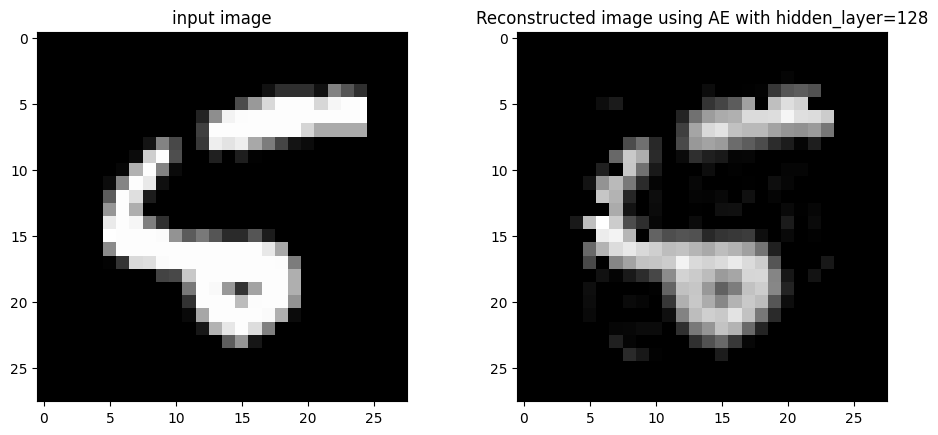

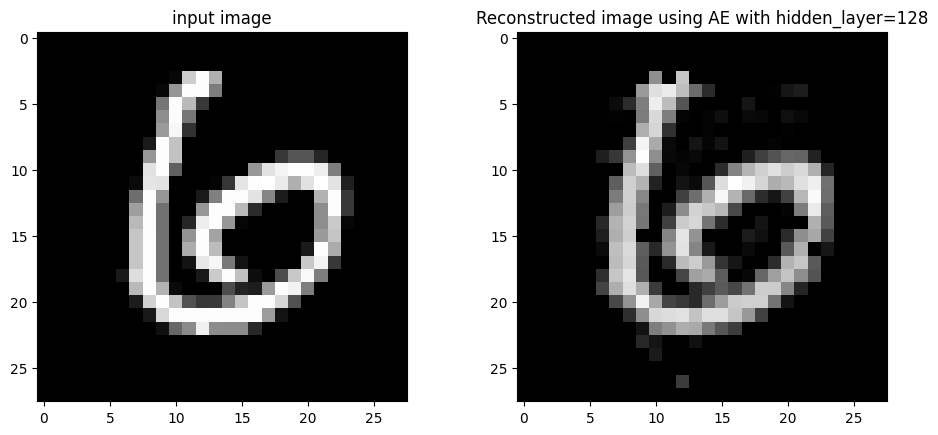

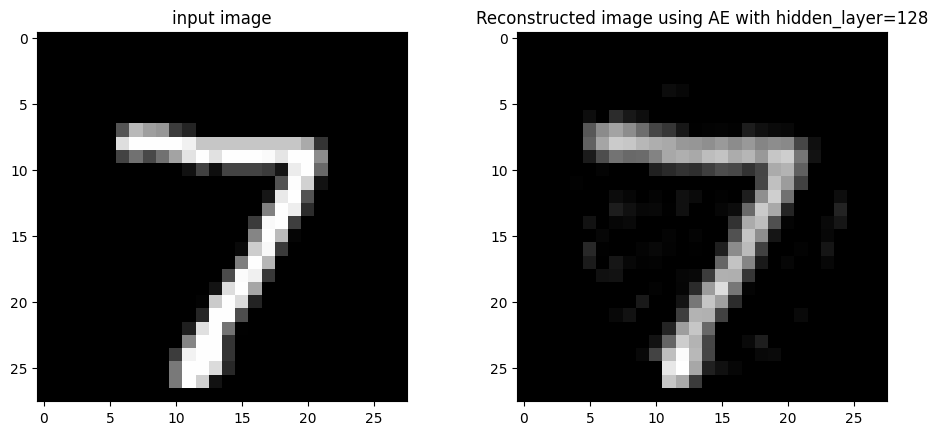

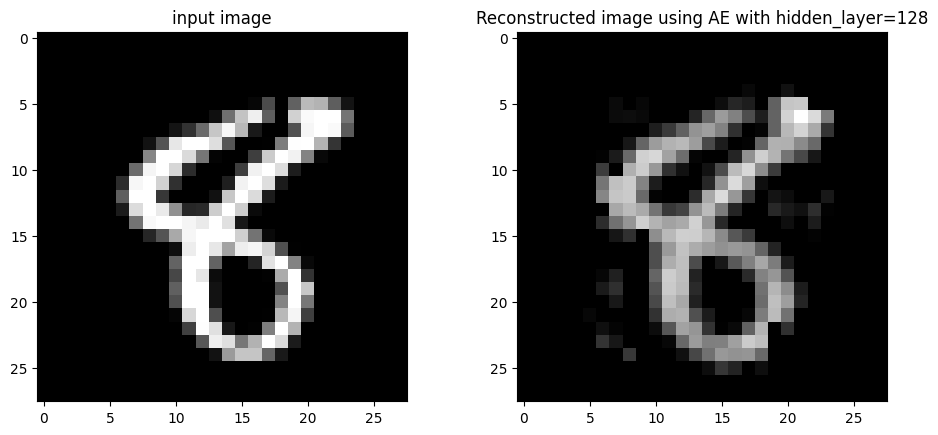

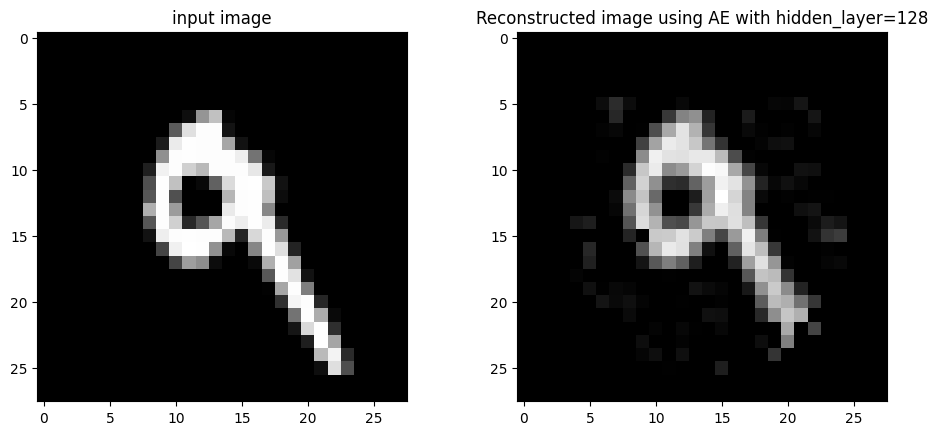

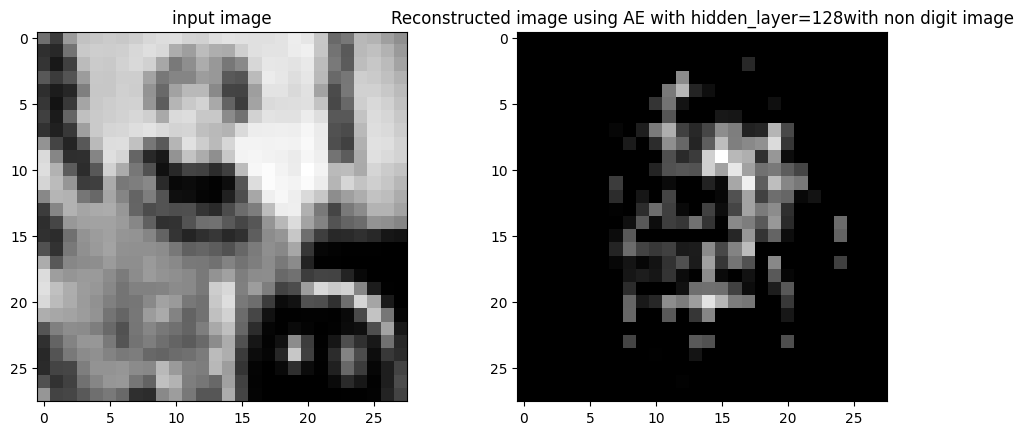

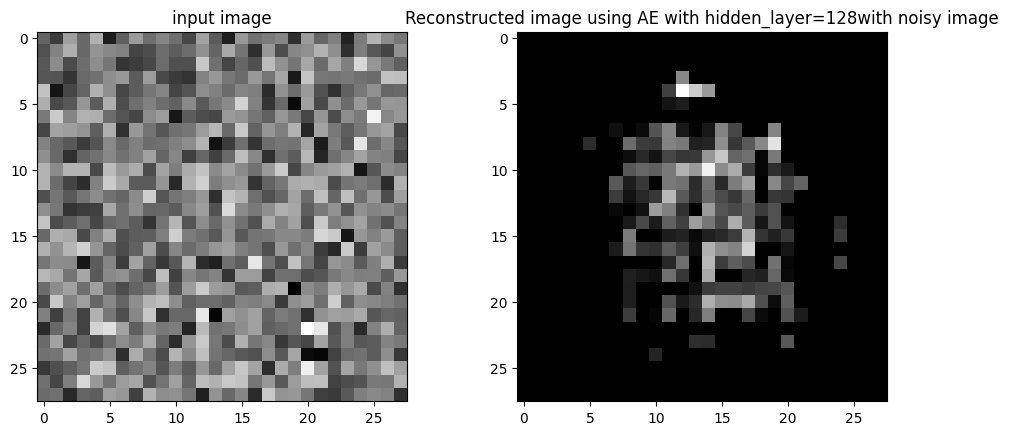

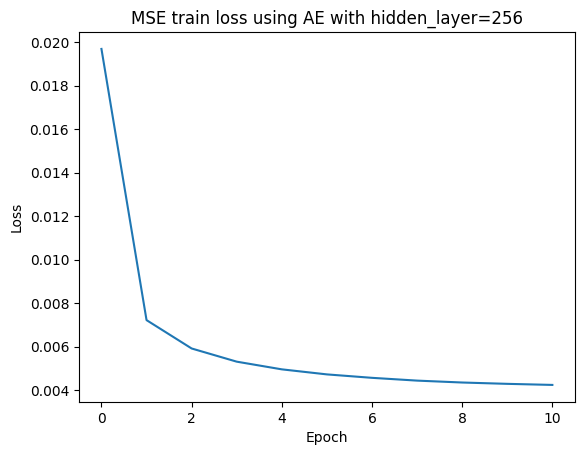

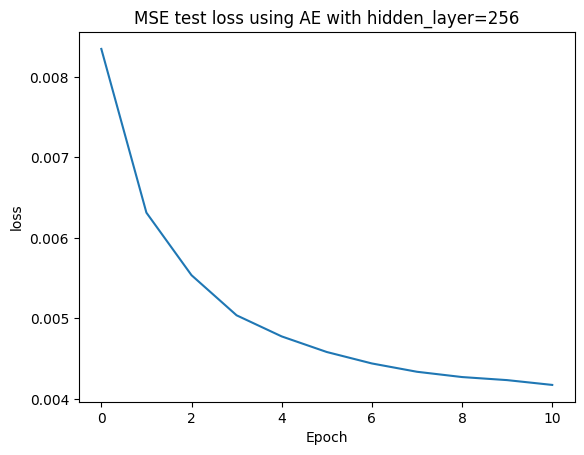

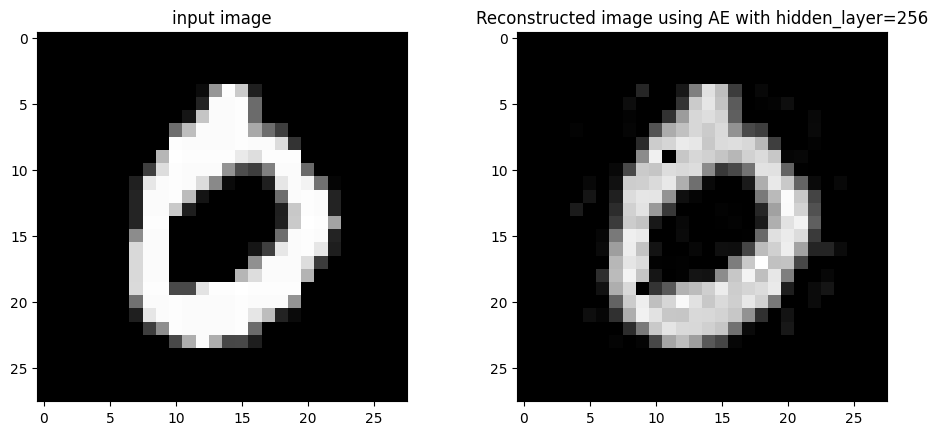

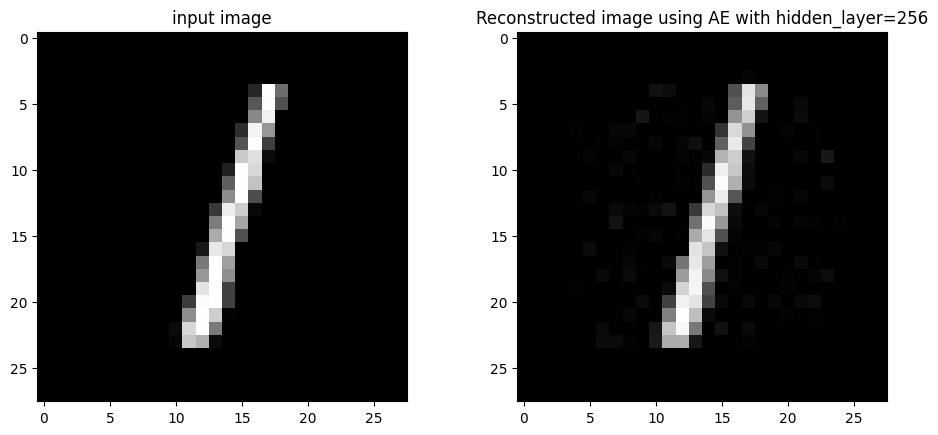

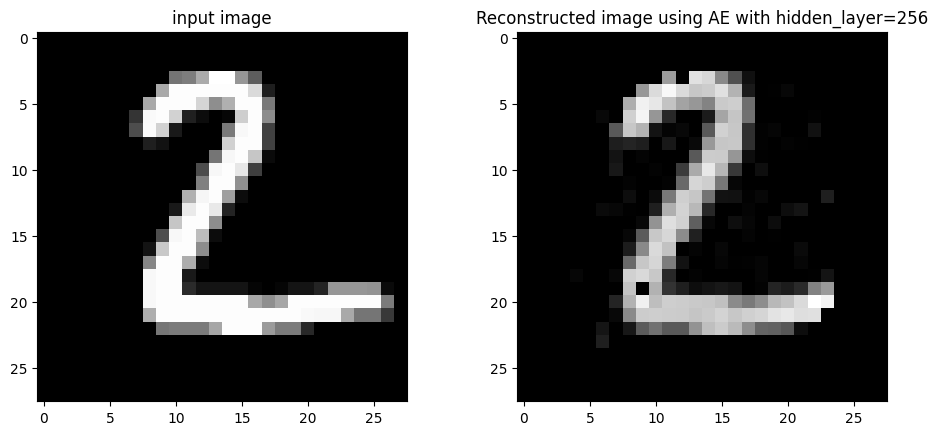

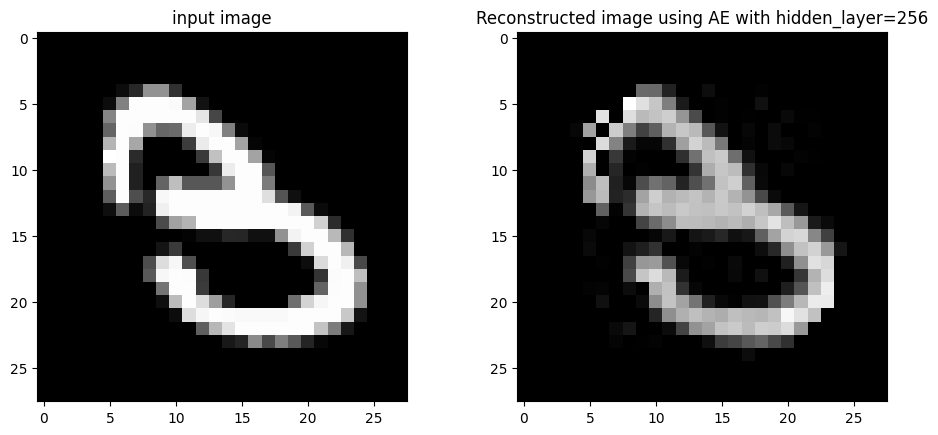

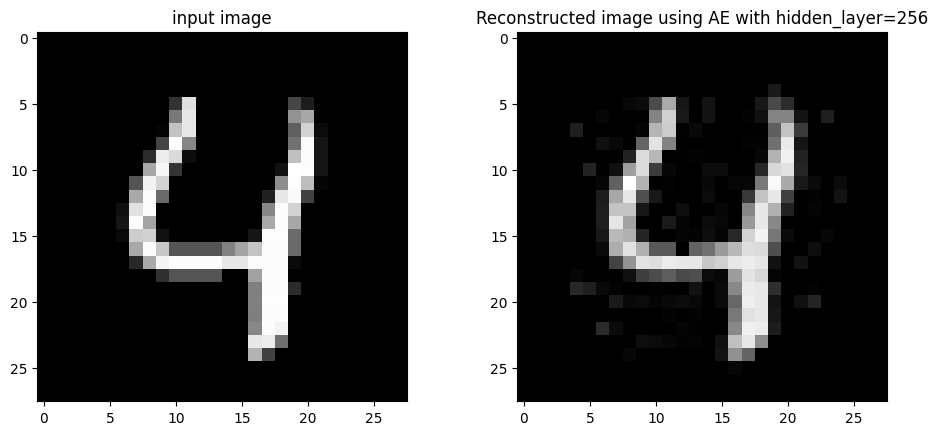

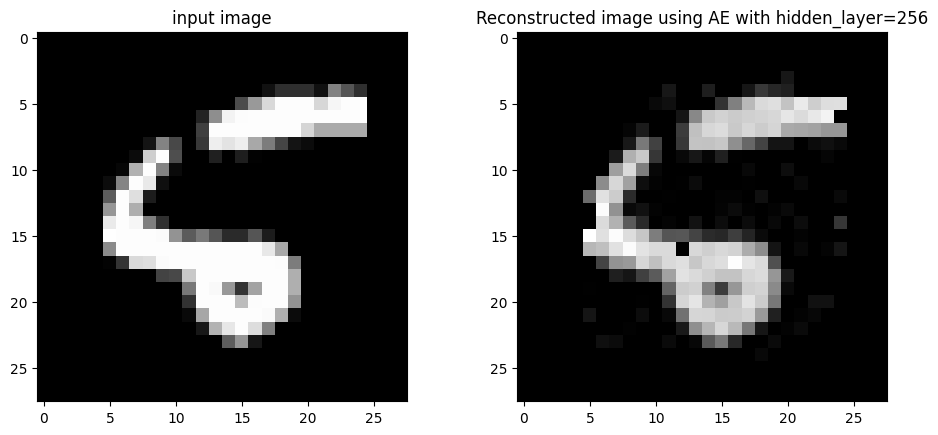

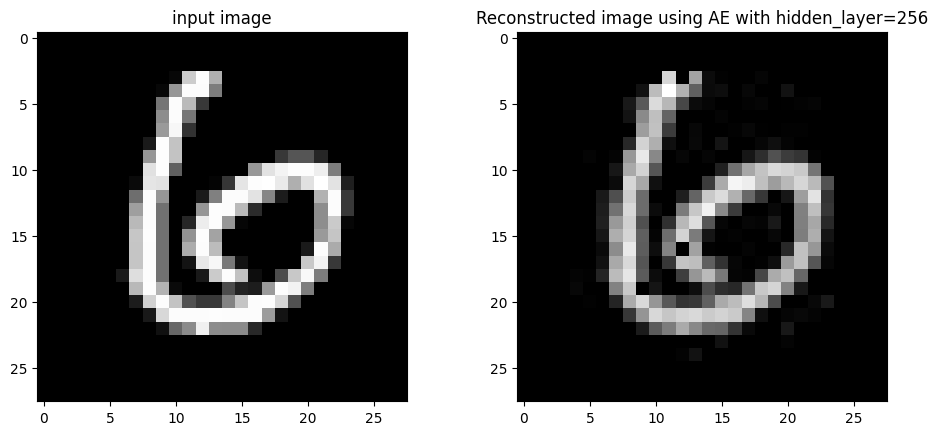

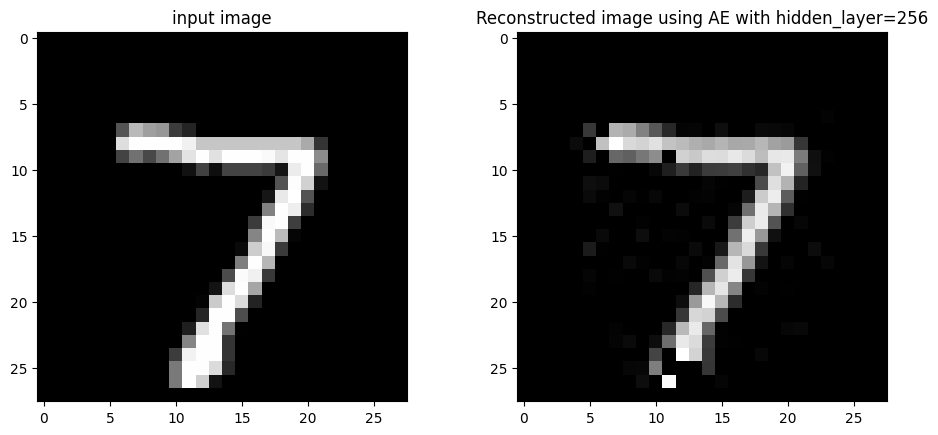

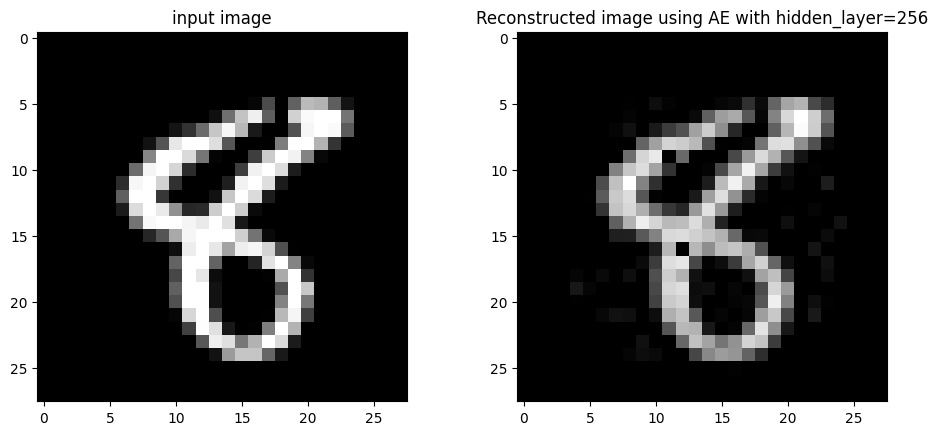

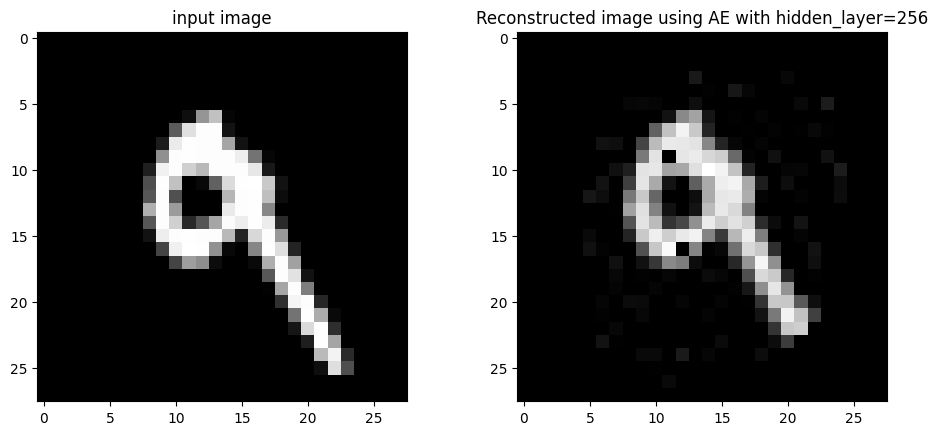

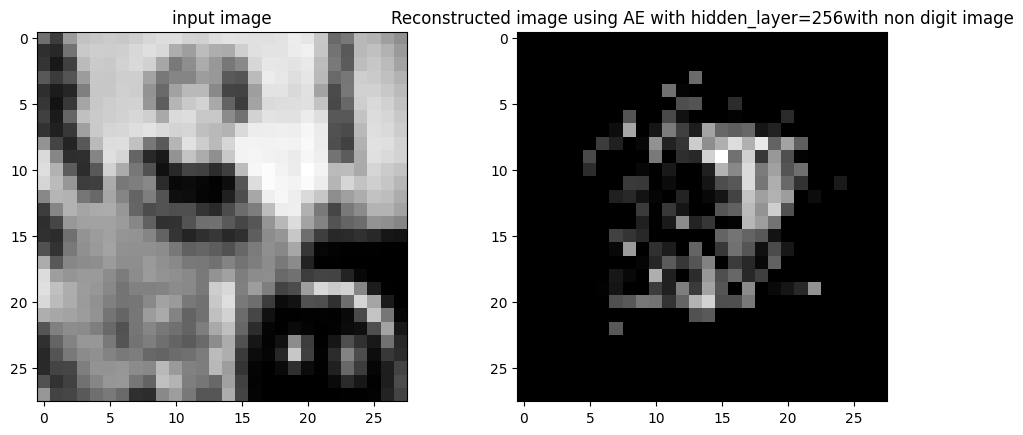

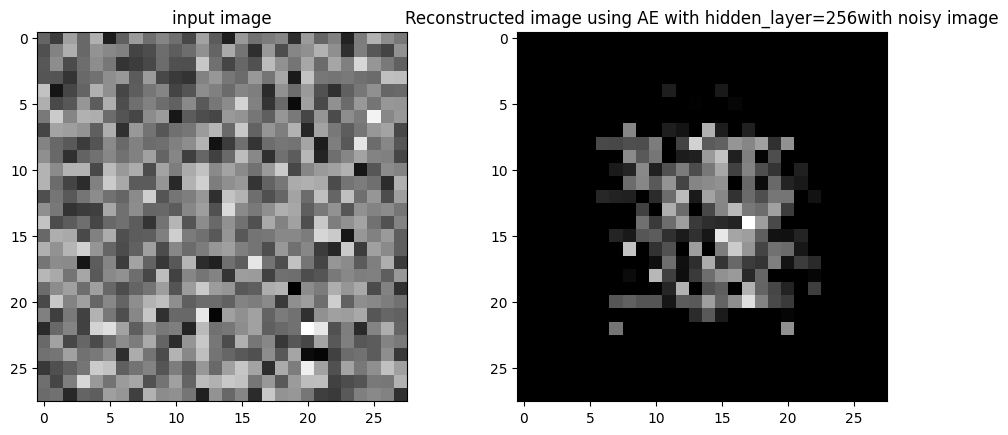

In [31]:
x = [64,128,256] #size of the hidden layer
for hidden_layer in x:
    model_Q2 = AE_Q2(hidden_layer=hidden_layer).to(device)
    optimizer = torch.optim.Adam(model_Q2.parameters(), lr=learning_rate)
    train_losses_AE_h , test_losses_AE_h = train_test(model_Q2,device,train_loader,test_loader,optimizer,lossfn)
    plot_losses(train_losses_AE_h, test_losses_AE_h, model_name = "AE with hidden_layer="+str(hidden_layer))
    for i in keys_test:
        test_image = test_loader.dataset.data[i, :, :].clone()
        plot_reconstructed_image(model_Q2,device,test_image, model_name="AE with hidden_layer="+str(hidden_layer))
    plot_reconstructed_image(model_Q2,device,non_digit_image, model_name="AE with hidden_layer="+str(hidden_layer)+"with non digit image")
    plot_reconstructed_image(model_Q2,device,noisy_image, model_name="AE with hidden_layer="+str(hidden_layer)+"with noisy image")

## Q3

In [32]:
class AE_Q3(nn.Module):
  def __init__(self):
    super(AE_Q3, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,1225),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(1225,784),
        nn.ReLU())
    
  def forward(self,x):
    x = flatten(x,1) #flatten the image to a 784x1 vector
    encoded_input = self.encoder(x.float())
    reconstructed_input = self.decoder(encoded_input)
    return reconstructed_input,encoded_input

In [33]:
def avg_hl_activations(model,test_dataloader,model_name):
    model.eval() 
    avg_act_val = 0
    with torch.no_grad():
        for (data,label) in test_dataloader: 
            (data,label) = (data.to(device),label.to(device))  
            reconstruction,encoded = model(data) #our prediction 
            avg_act_val += float(torch.mean(encoded))        
    avg_act_val /= len(test_dataloader)
    print("The average activation of "+ str(model_name)+" is",avg_act_val)

In [34]:
def encoder_decoder_filters_plots(model,model_name,device): 
    with torch.no_grad():
        encoder_filters = model.encoder[0].weight.detach().cpu().numpy()
        decoder_filters = model.decoder[0].weight.detach().cpu().numpy()
        #plot the encoder and decoder weights as an image for 0th neuron
        plt.imshow(encoder_filters[0].reshape(28,28), cmap='gray')
        plt.colorbar()
        plt.title('Encoder Filters for '+str(0)+'th neuron of '+ str(model_name))
        plt.show()

        plt.imshow(decoder_filters[:,0].reshape(28,28), cmap='gray')
        plt.colorbar()
        plt.title('Decoder Filters for '+str(0)+'th neuron of '+ str(model_name))
        plt.show()

In [35]:
def visualize_activations(model,test_dataloader,model_name,device,hidden_layer): #visualize the activations
    # data_ind  = np.random.randint(low=0, high=9999, size=5)
    for i,ind in enumerate(keys_test):
        test_image = test_dataloader.dataset.data[ind].clone()  
        test_label = test_dataloader.dataset.targets[ind].clone()
        with torch.no_grad():
            if(device == torch.device("cuda")): 
                test_image = test_image.reshape(1,1,28,28).cuda().float() 
            else:
                test_image = test_image.reshape(1,1,28,28).float()
            reconstructed_image,encoded = model.forward(test_image) 
            encoded = encoded.detach().cpu().numpy()
            plt.imshow(encoded.reshape(int(np.sqrt(hidden_layer)),int(np.sqrt(hidden_layer))), cmap='gray') 
            str_title = "Activation for digit "+str(test_label.item())
            plt.title(str_title)
            plt.show()

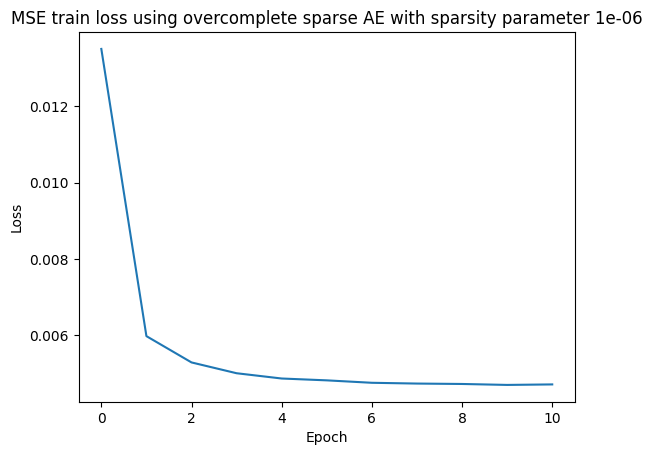

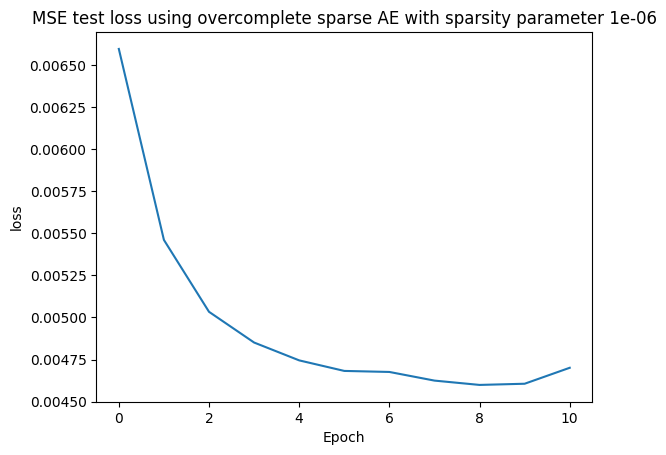

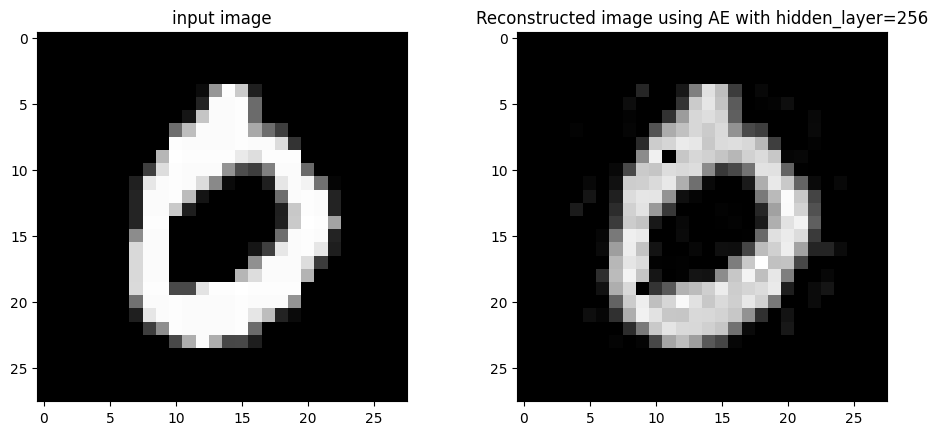

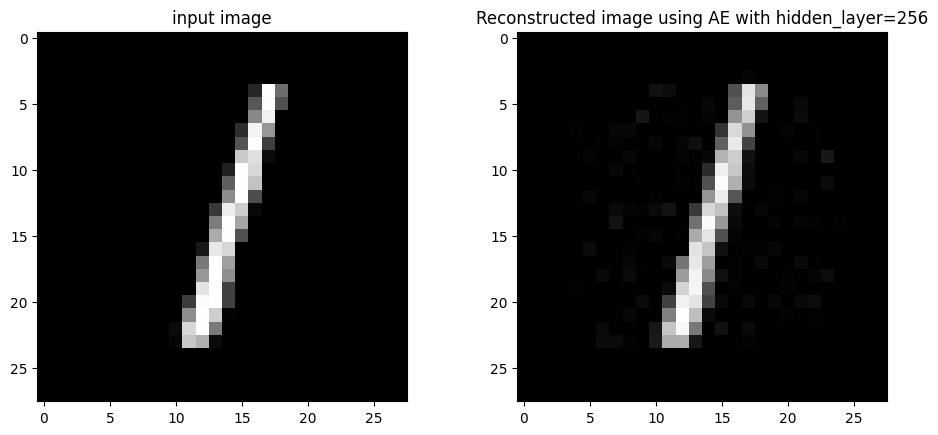

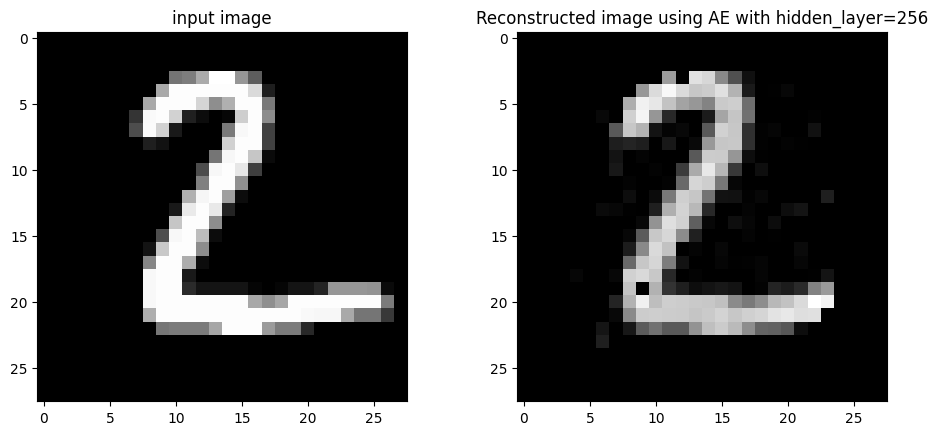

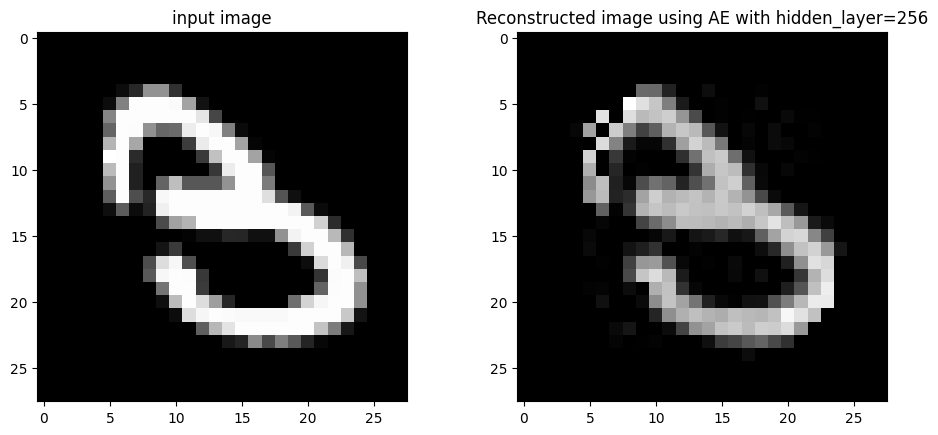

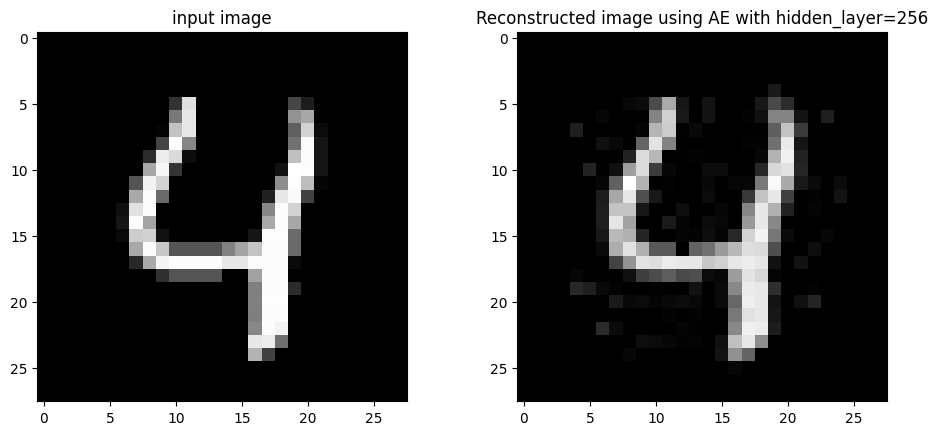

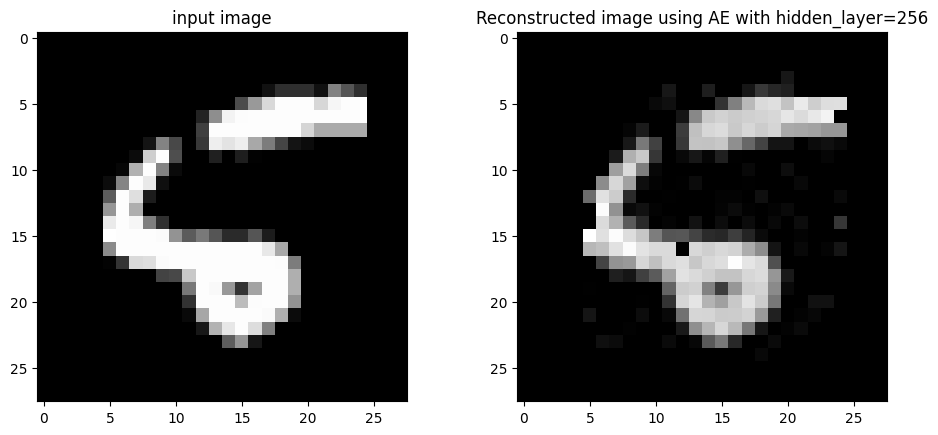

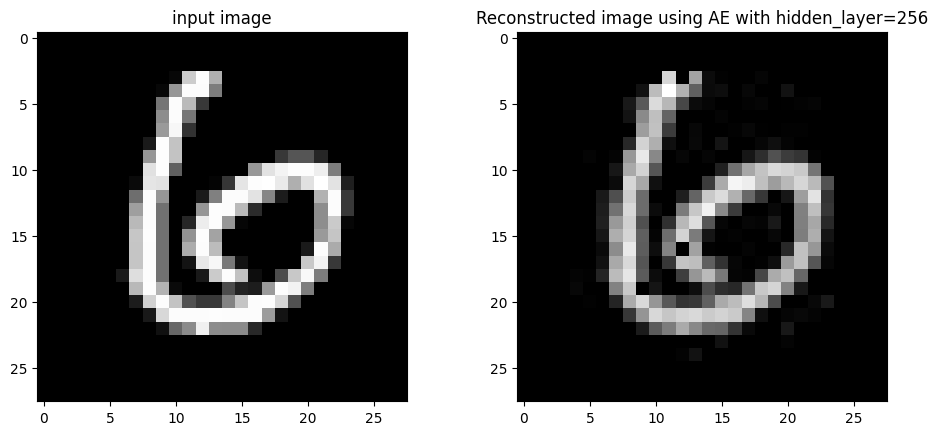

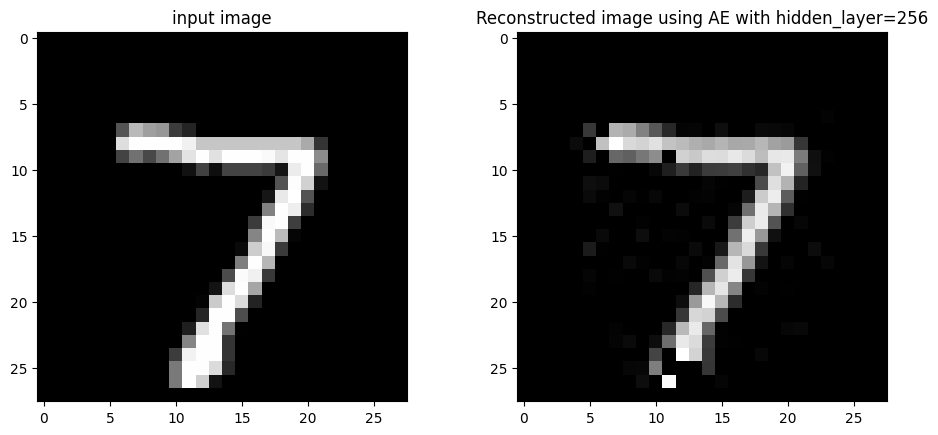

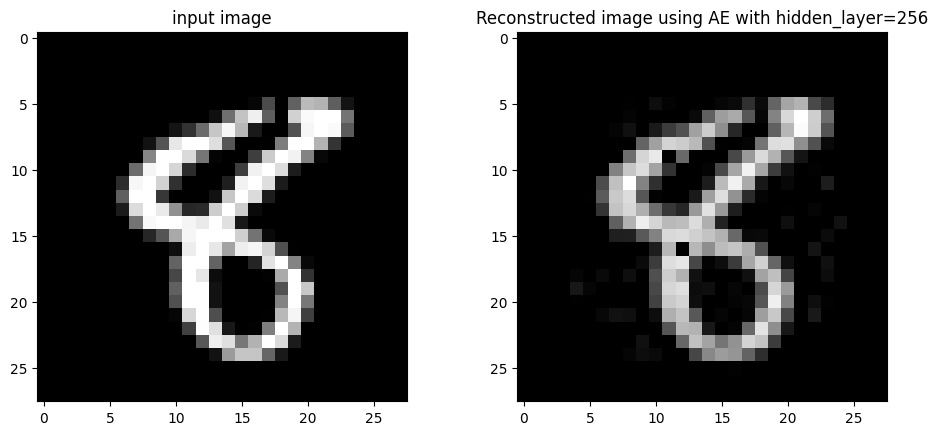

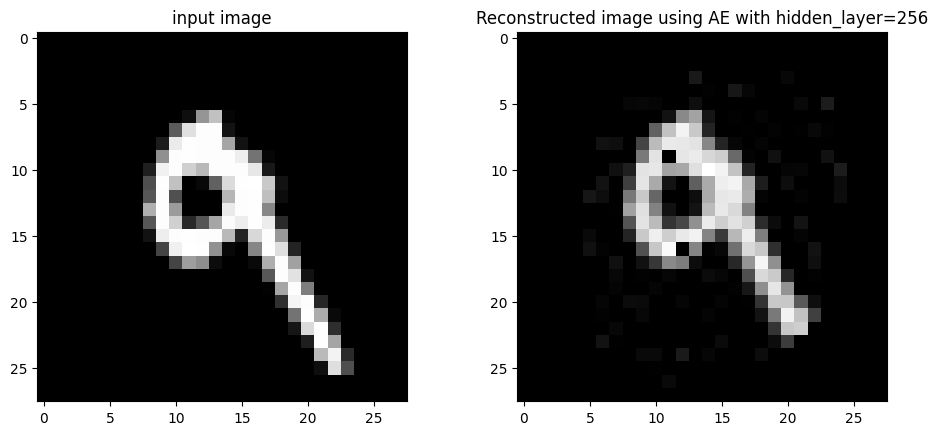

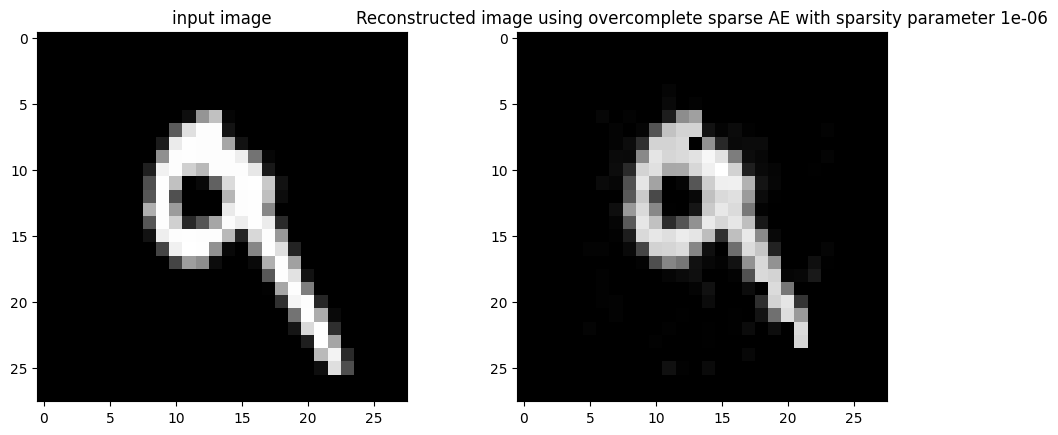

The average activation of overcomplete sparse AE with sparsity parameter 1e-06 is 0.27716308906674386


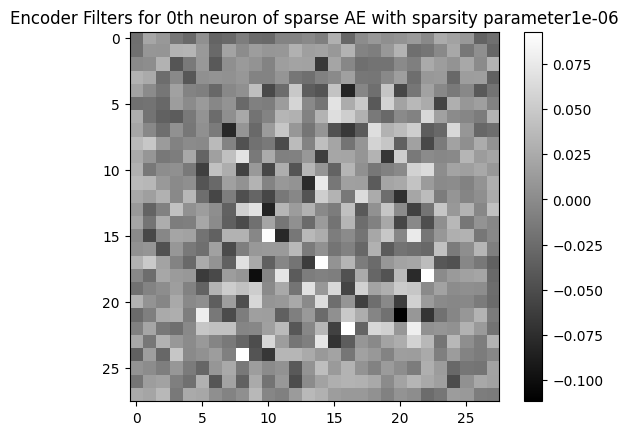

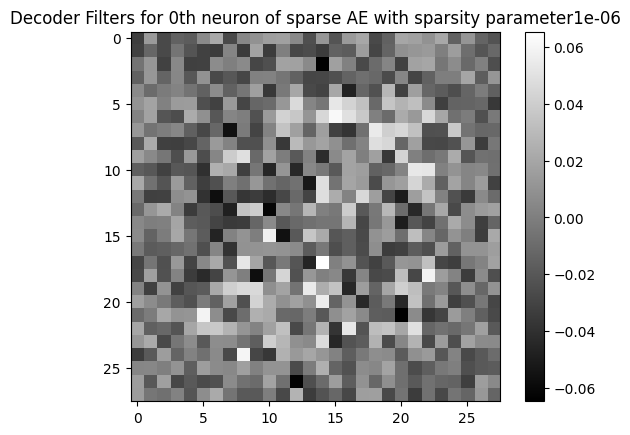

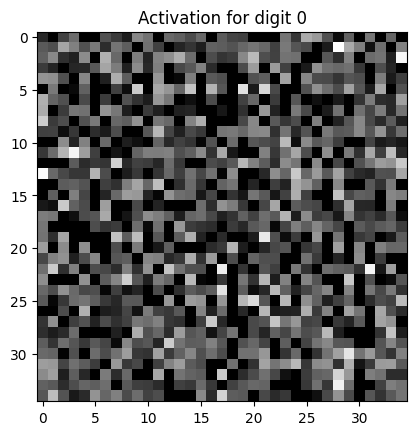

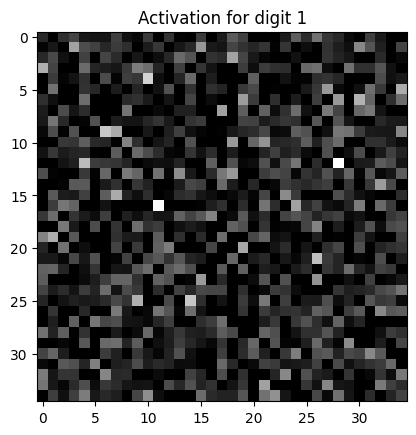

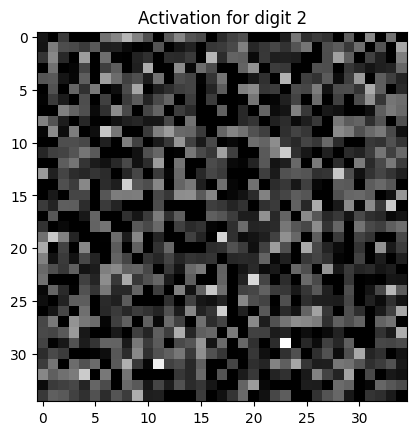

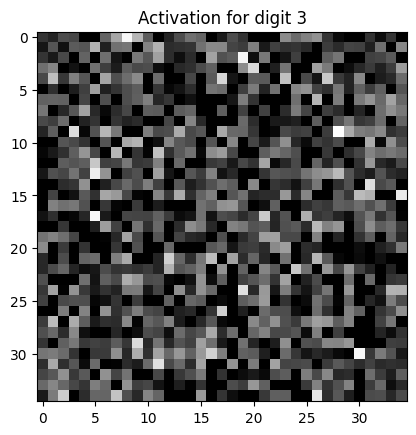

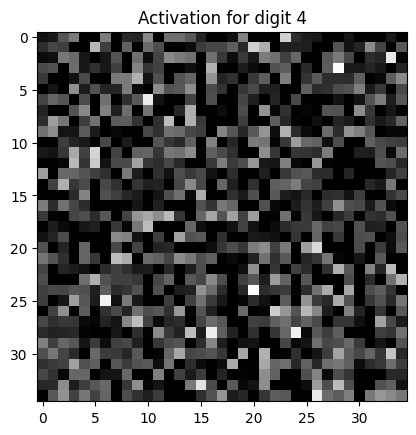

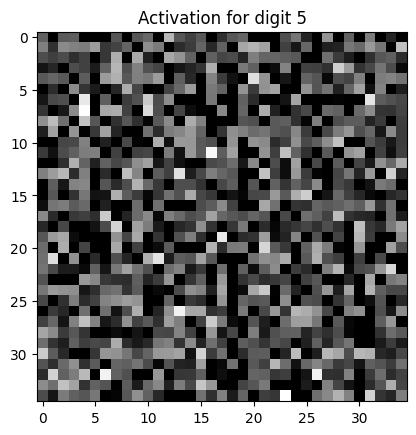

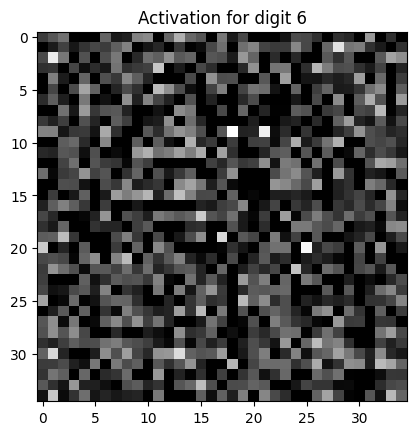

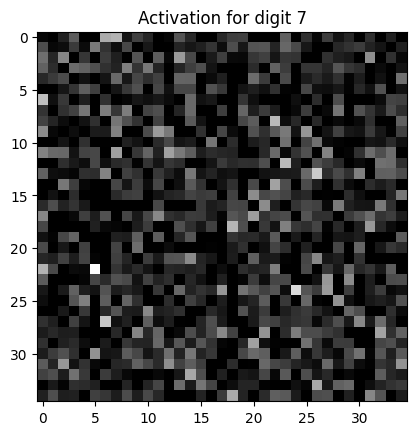

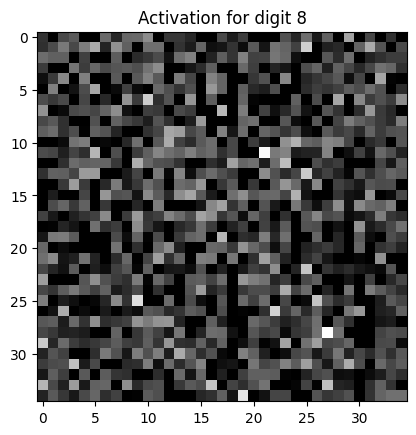

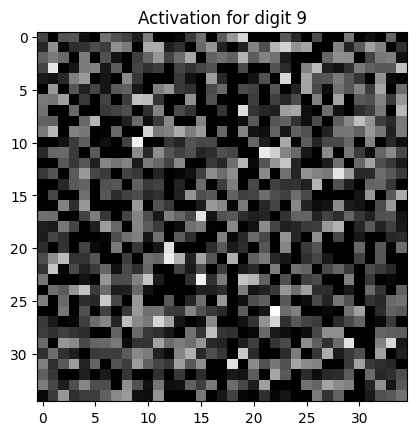

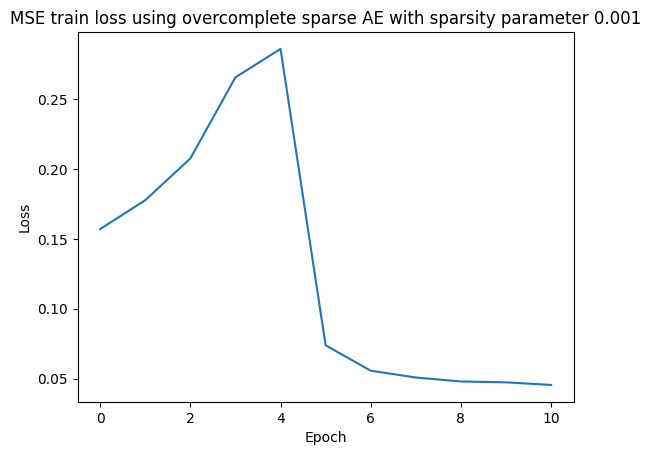

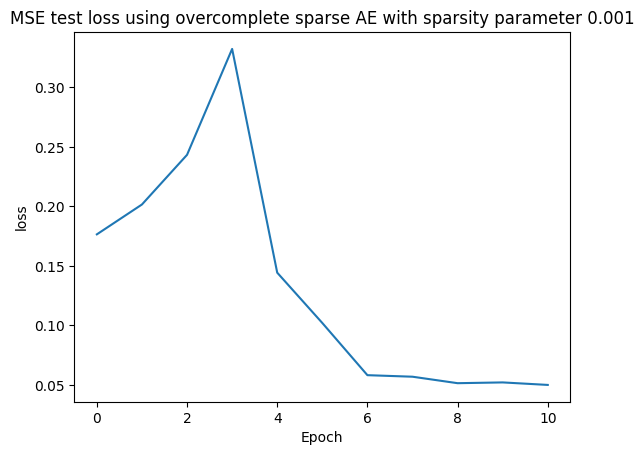

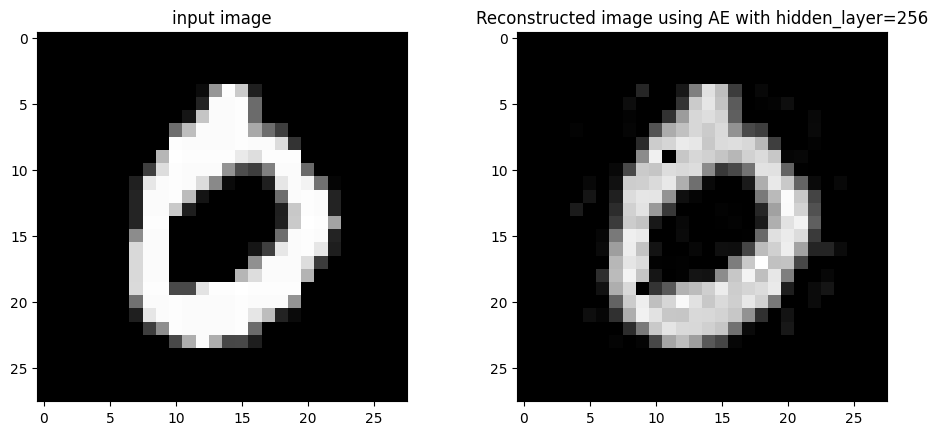

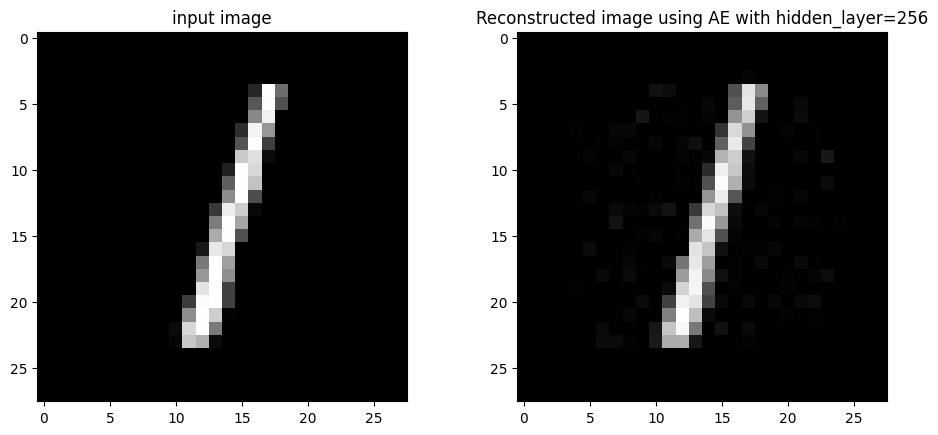

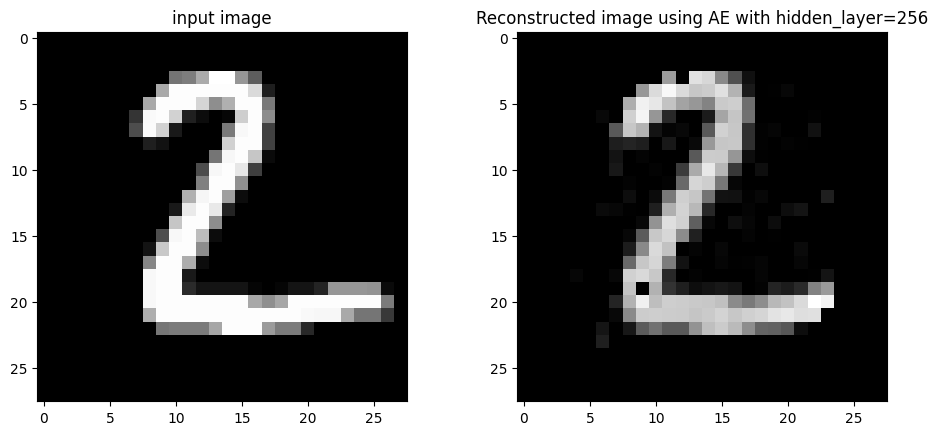

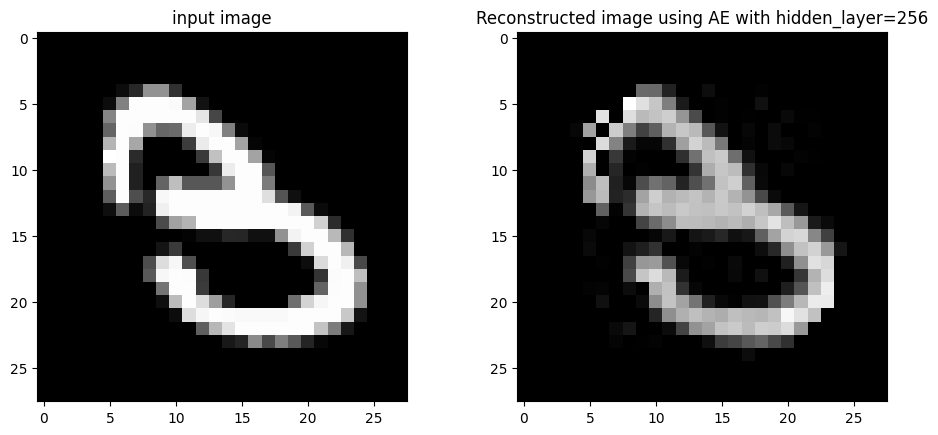

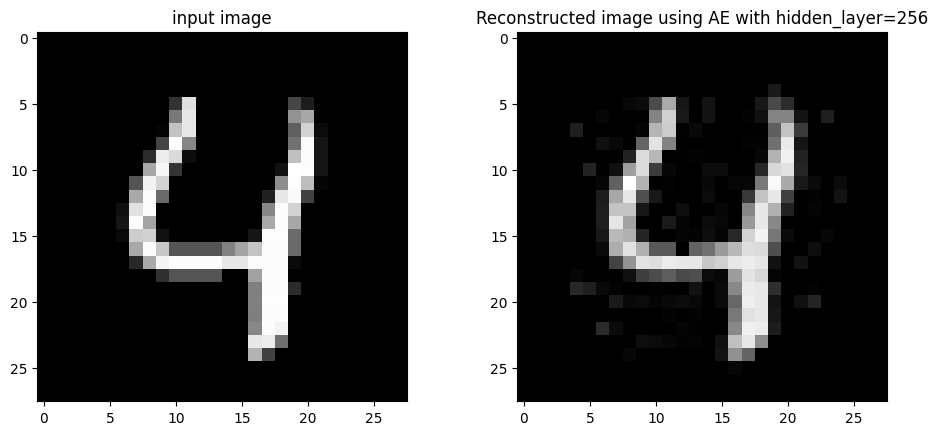

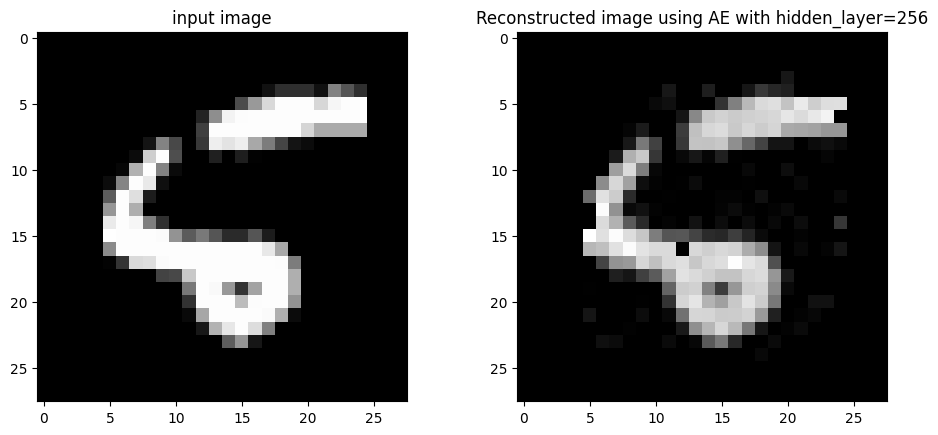

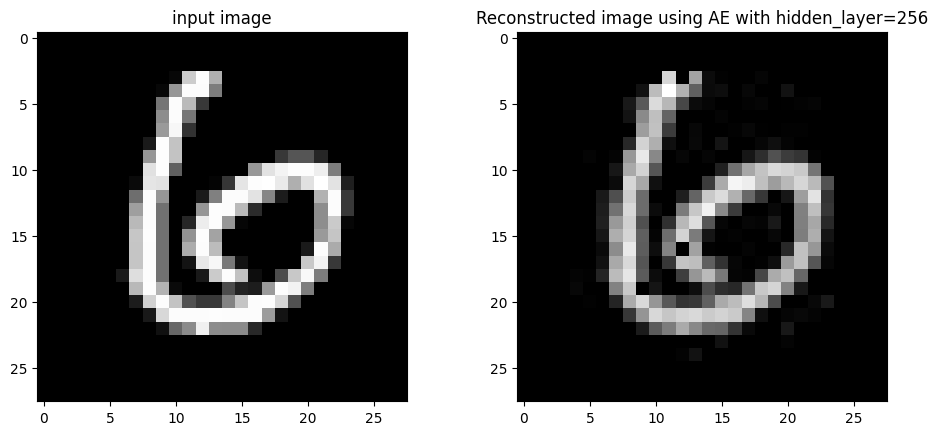

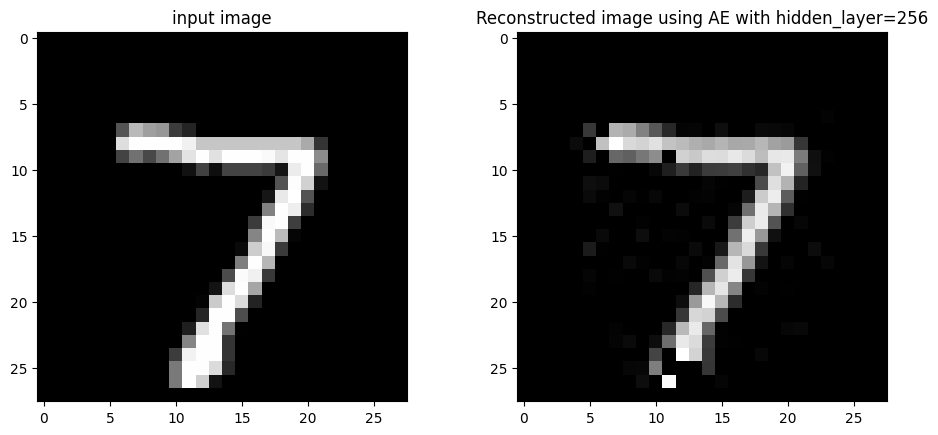

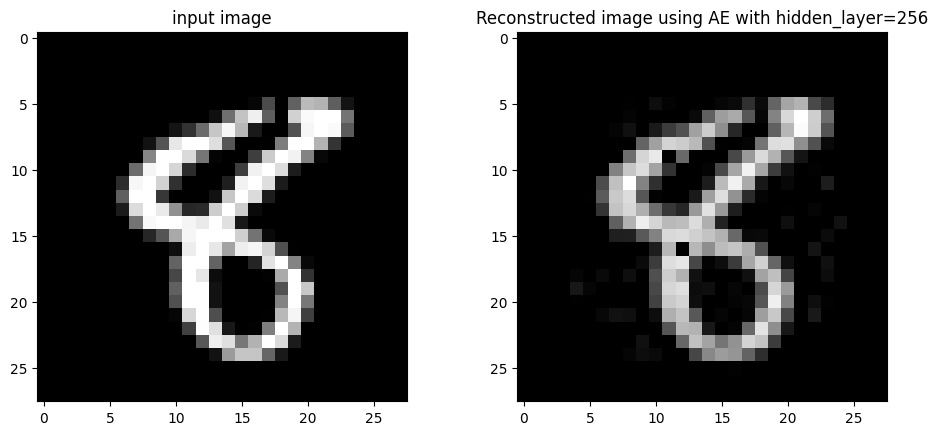

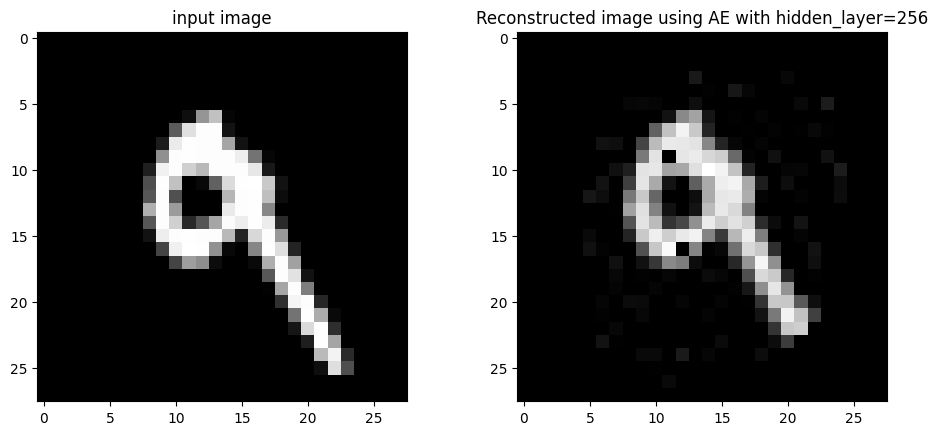

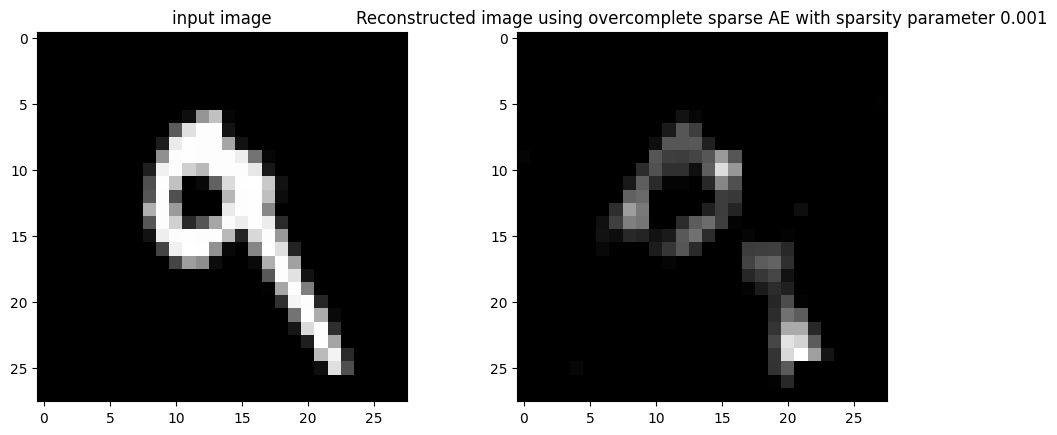

The average activation of overcomplete sparse AE with sparsity parameter 0.001 is 0.004904146178159863


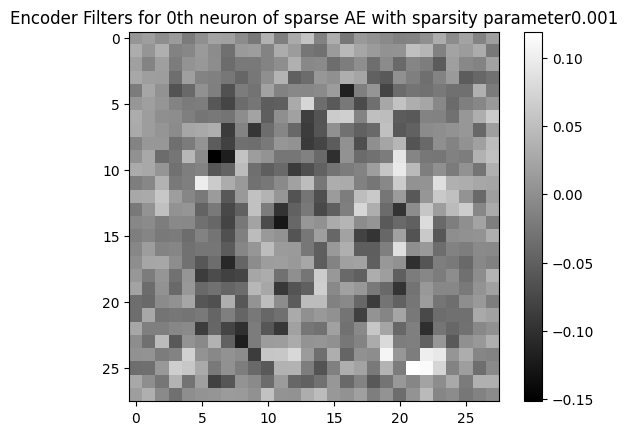

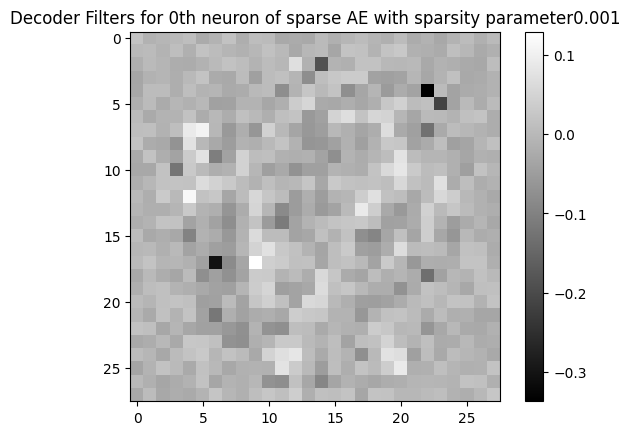

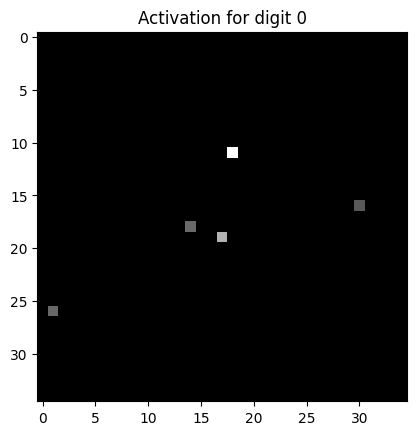

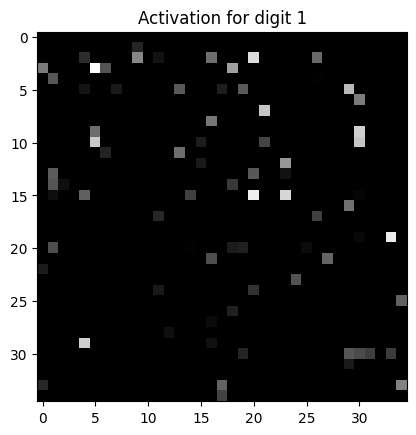

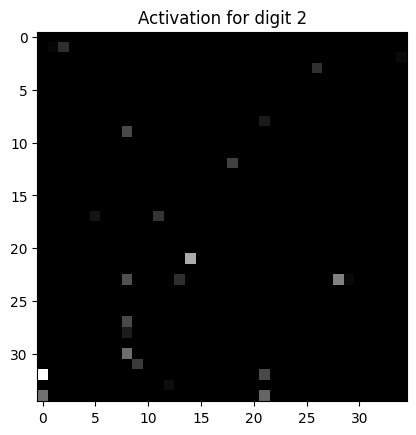

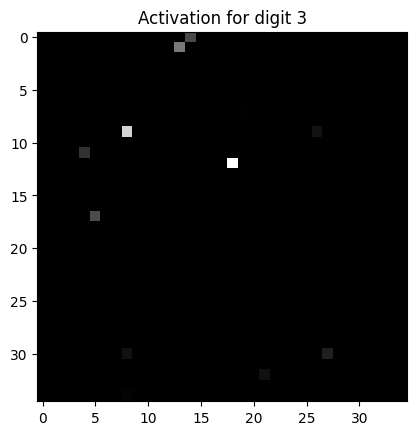

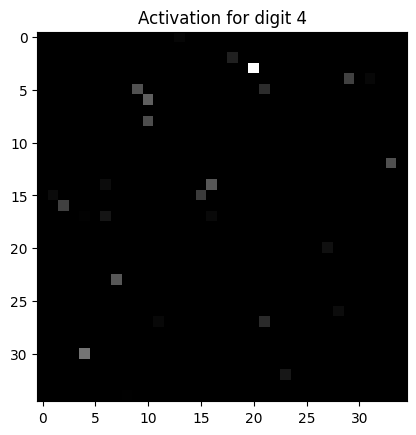

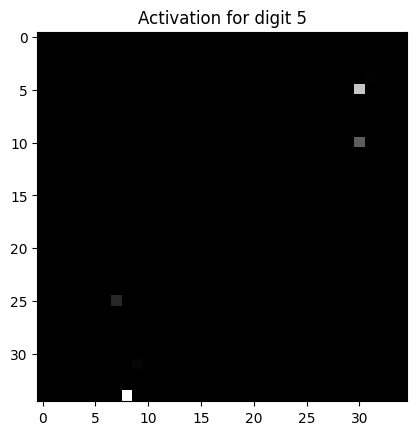

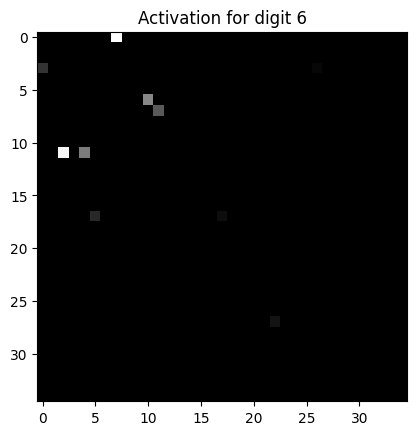

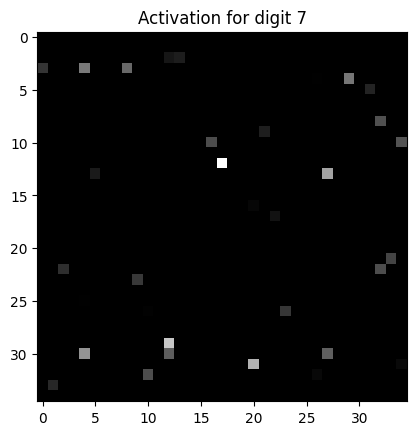

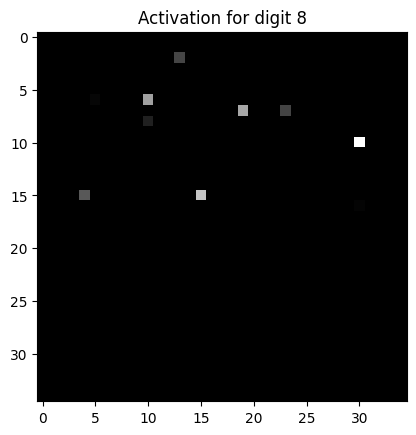

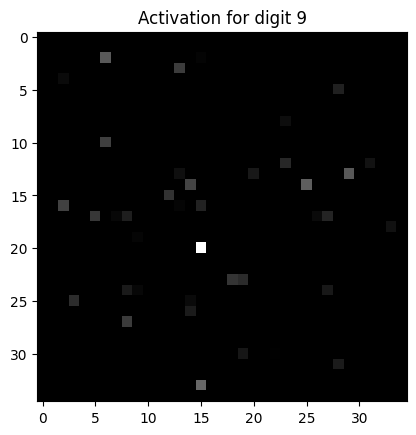

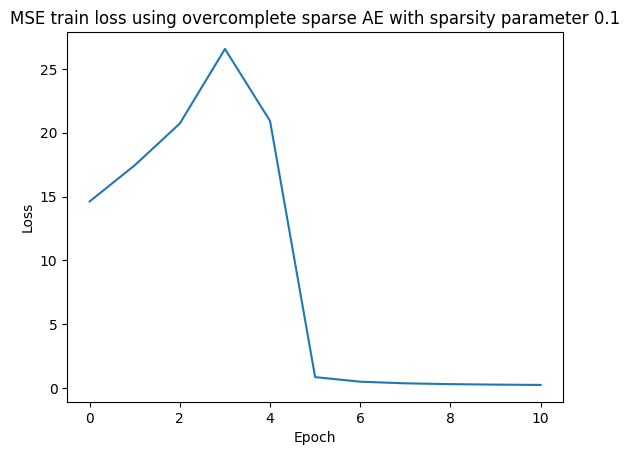

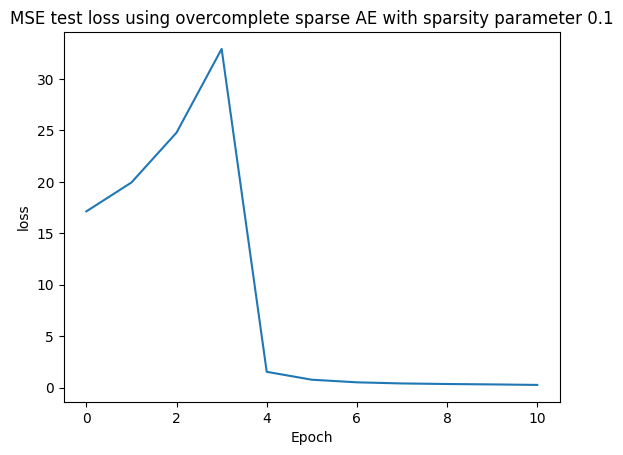

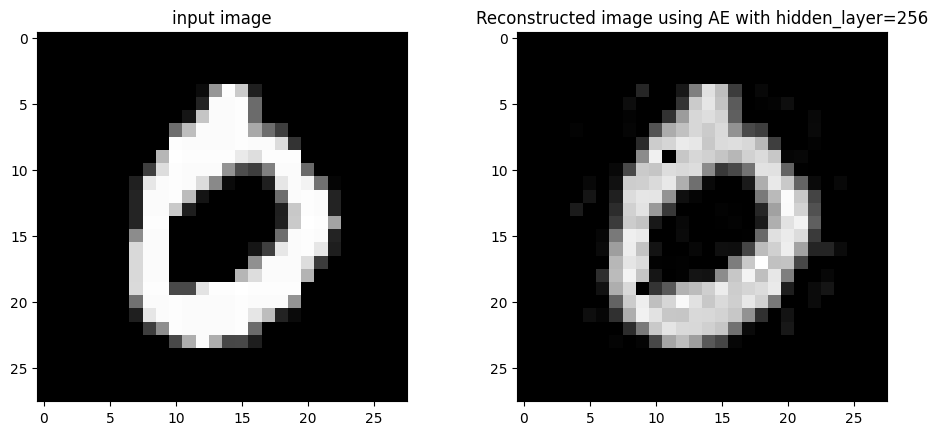

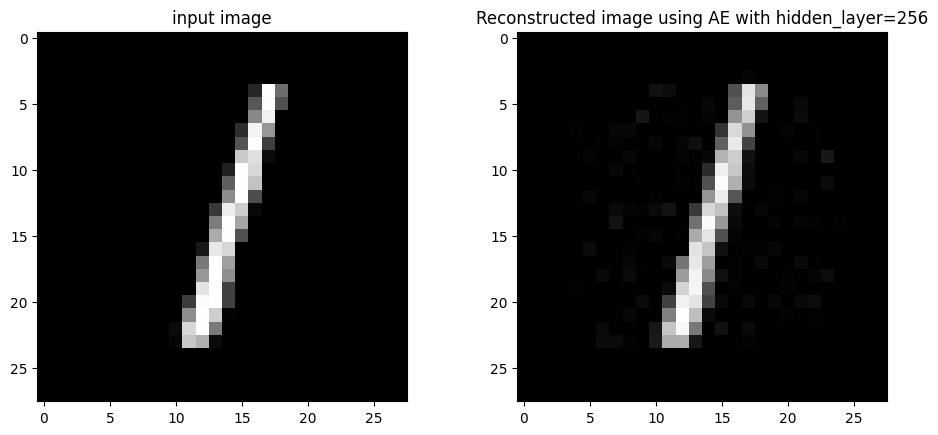

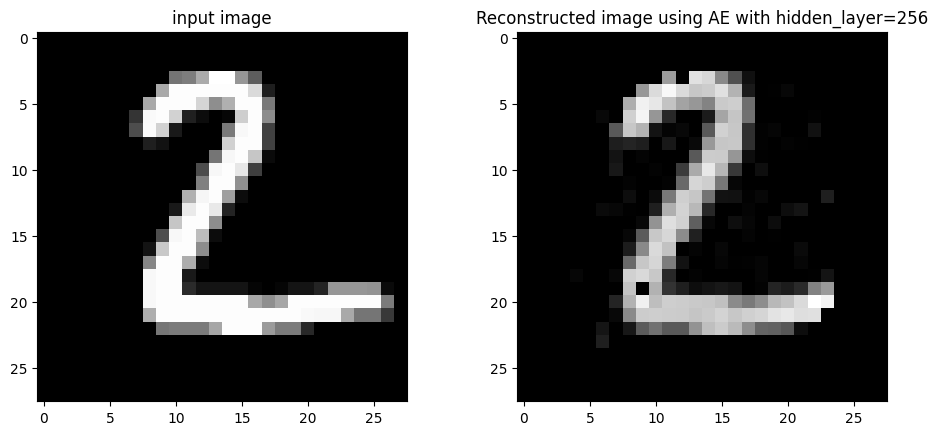

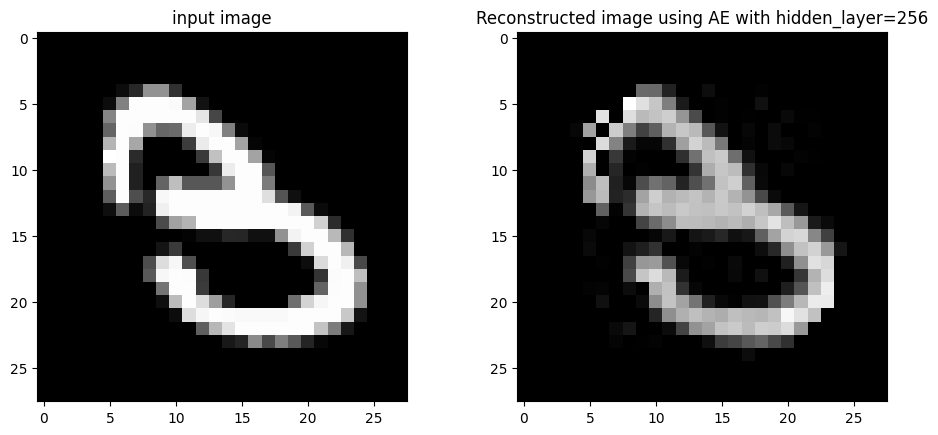

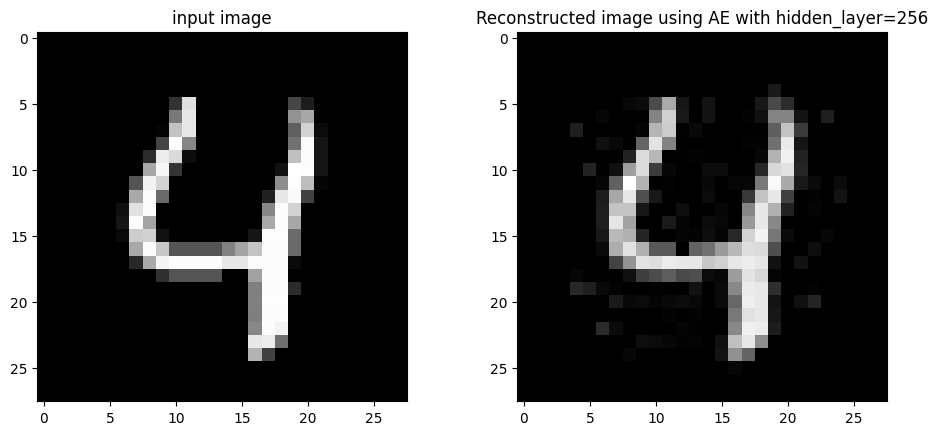

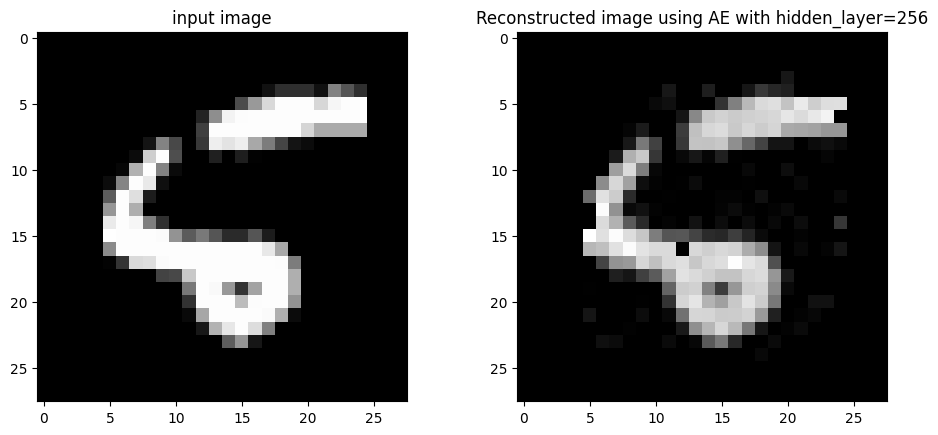

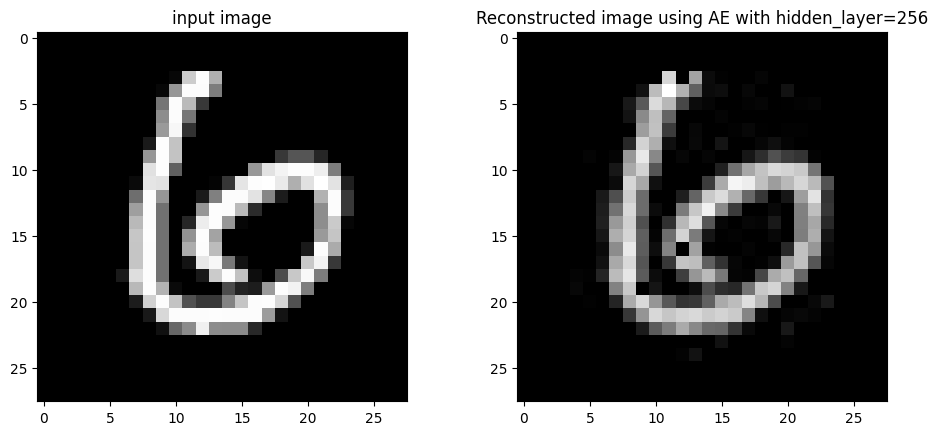

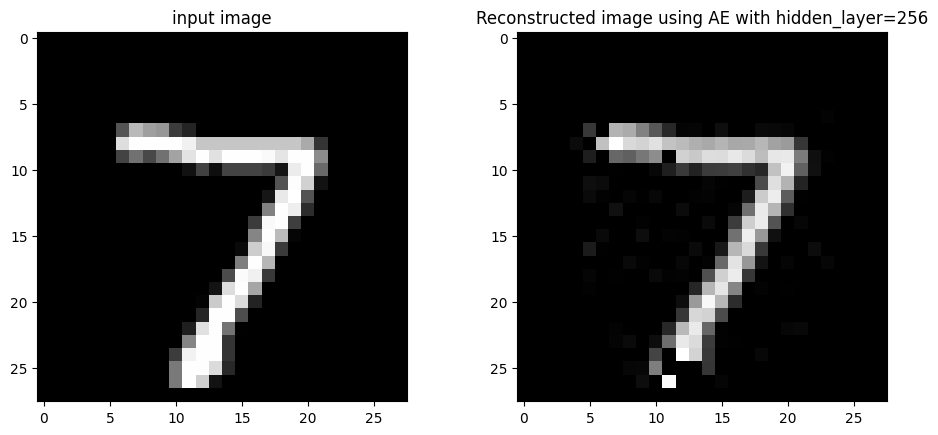

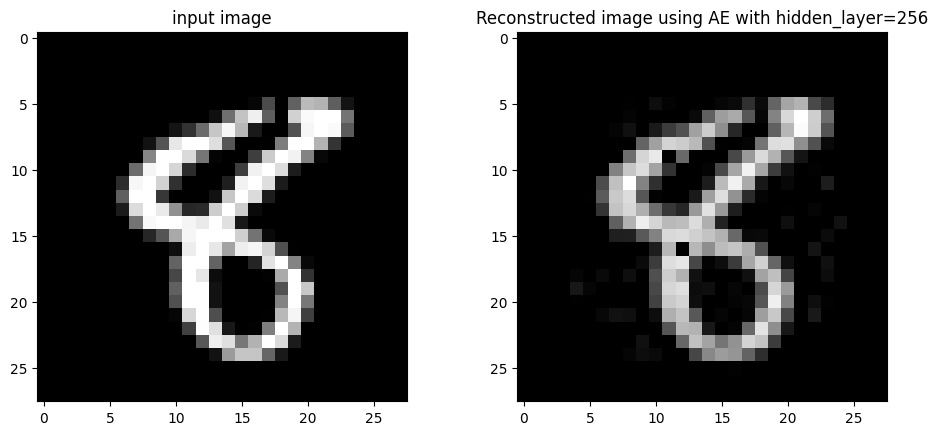

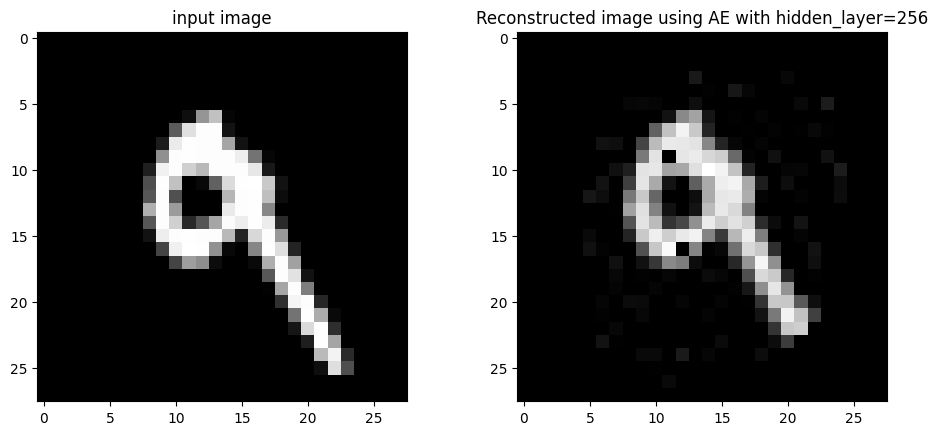

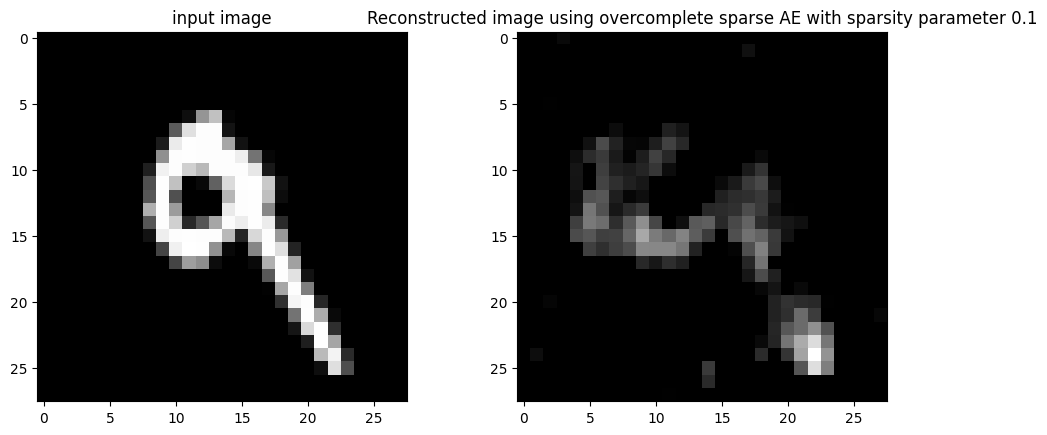

The average activation of overcomplete sparse AE with sparsity parameter 0.1 is 0.0004624879096809309


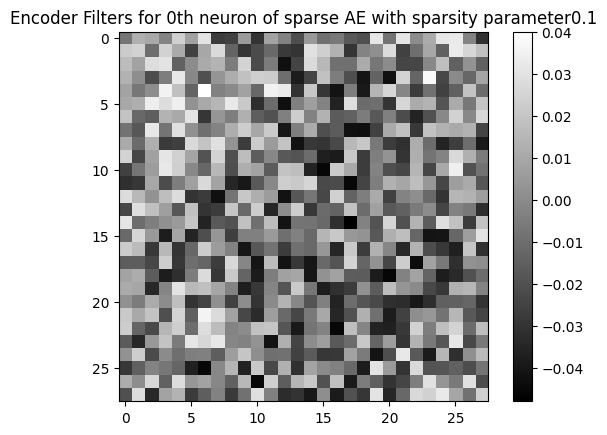

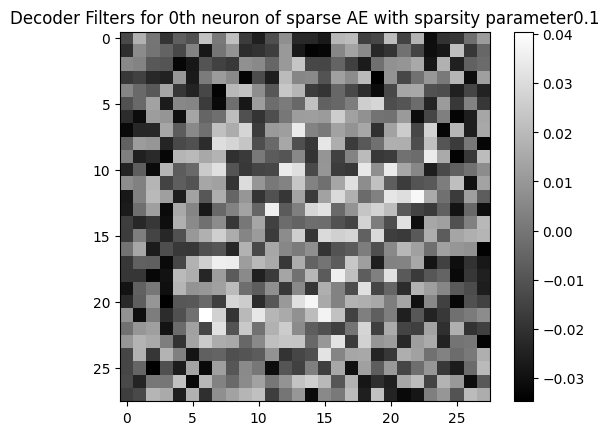

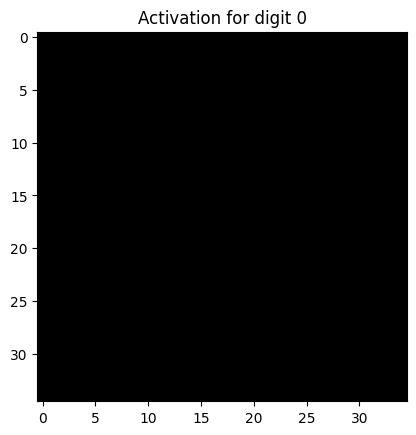

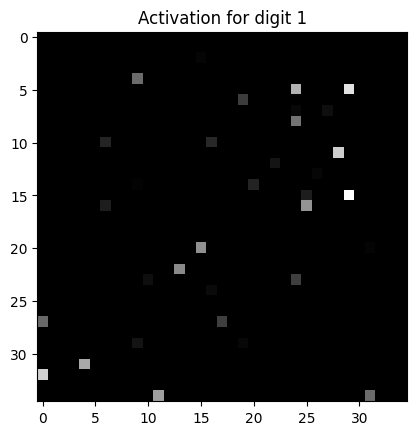

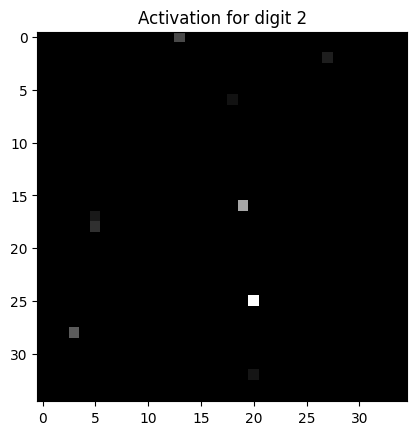

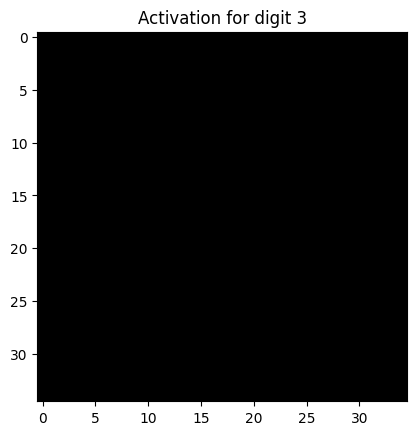

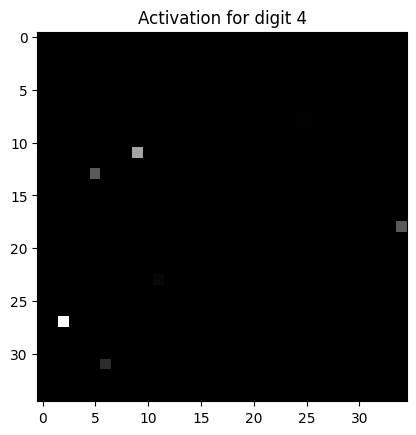

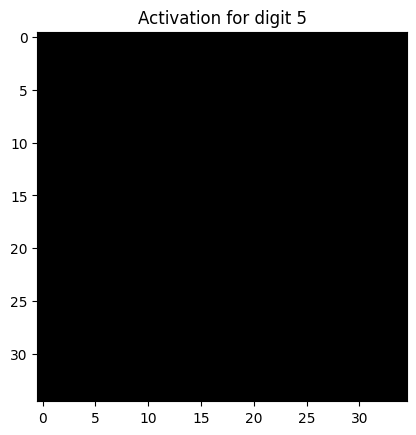

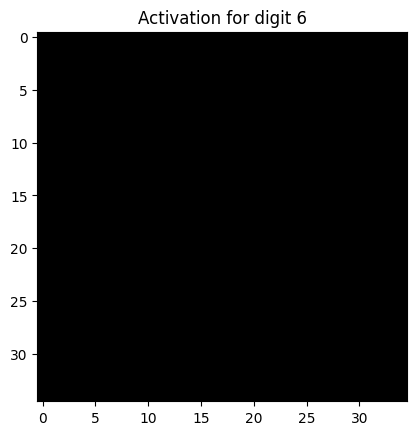

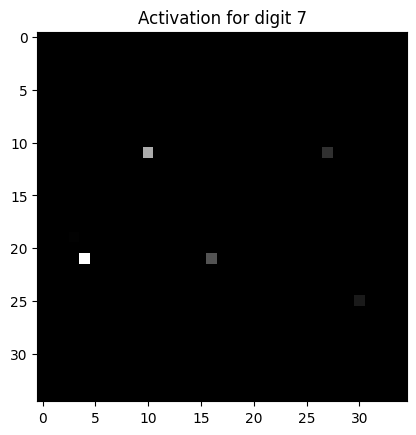

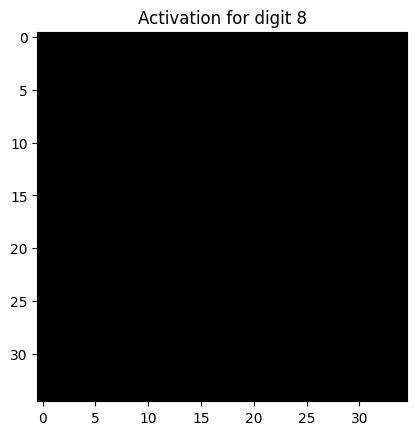

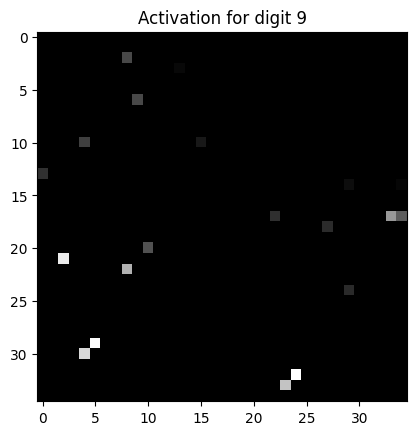

In [36]:
lambda_reg_vals=[0.000001, 0.001, 0.1]  
for lambda_reg in lambda_reg_vals:
    model_Q3 = AE_Q3().to(device)
    optimizer = torch.optim.Adam(model_Q3.parameters(), lr=learning_rate)
    train_losses_AE_Q3 , test_losses_AE_Q3 = train_test(model_Q3,device,train_loader,test_loader,optimizer,lossfn,lambda_reg,sparse=True)
    plot_losses(train_losses_AE_Q3, test_losses_AE_Q3, model_name = "overcomplete sparse AE with sparsity parameter "+str(lambda_reg))
    for i in keys_test:
        test_image = test_loader.dataset.data[i, :, :].clone()
        plot_reconstructed_image(model_Q2,device,test_image, model_name="AE with hidden_layer="+str(hidden_layer))
    plot_reconstructed_image(model_Q3,device,test_image, model_name="overcomplete sparse AE with sparsity parameter "+str(lambda_reg))
    avg_hl_activations(model_Q3,test_loader,"overcomplete sparse AE with sparsity parameter "+str(lambda_reg))
    encoder_decoder_filters_plots(model_Q3,"sparse AE with sparsity parameter"+str(lambda_reg),device)
    visualize_activations(model_Q3,test_loader,"sparse AE with sparsity parameter"+str(lambda_reg),device,1225)

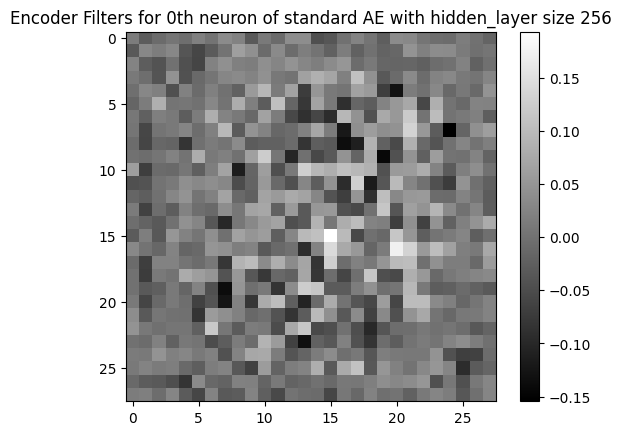

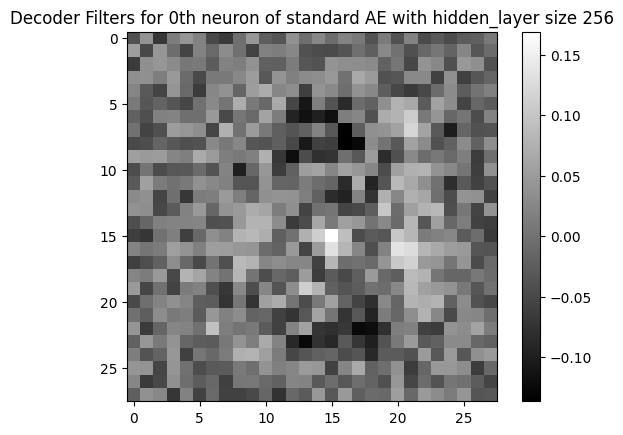

In [37]:
encoder_decoder_filters_plots(model_Q2,"standard AE with hidden_layer size 256",device)

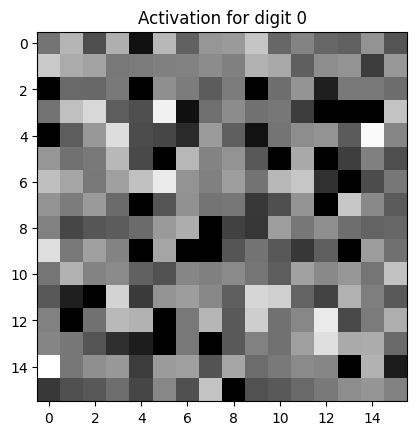

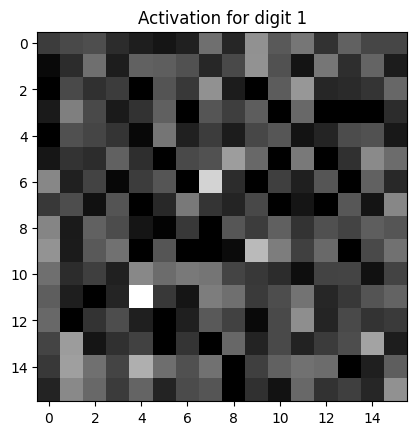

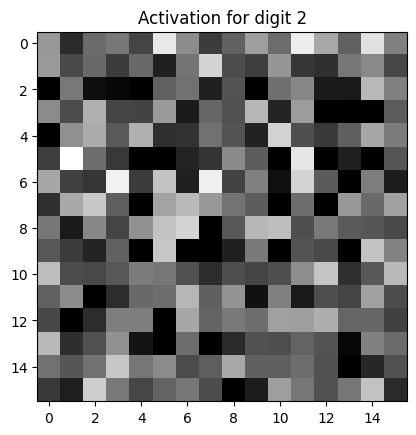

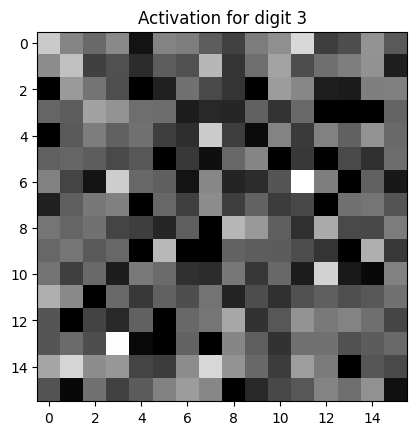

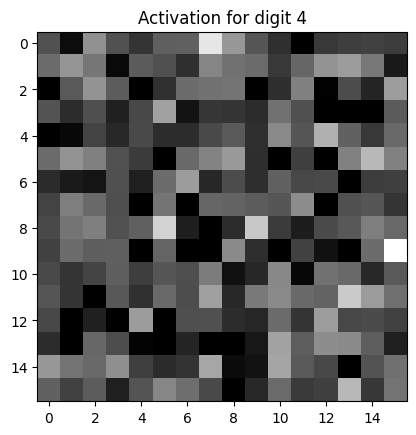

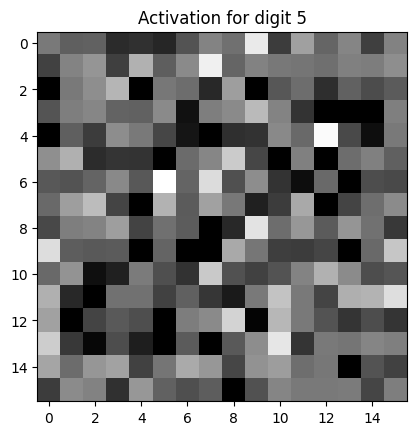

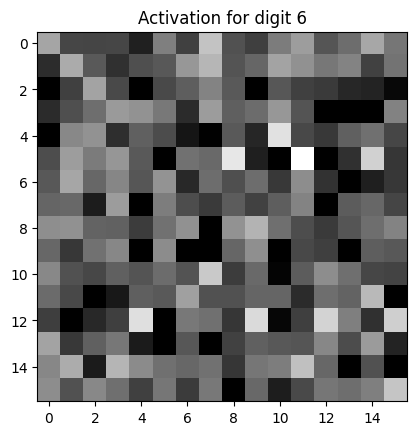

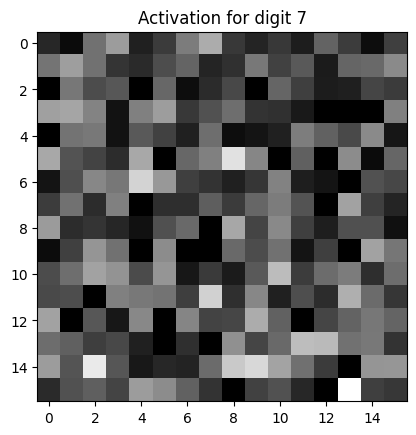

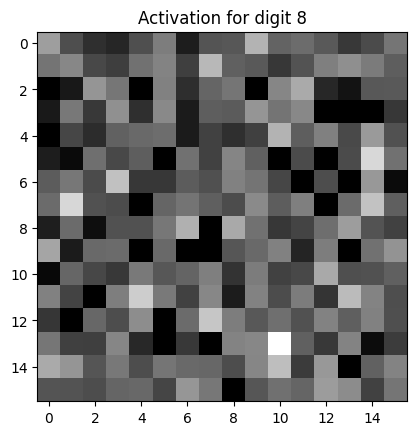

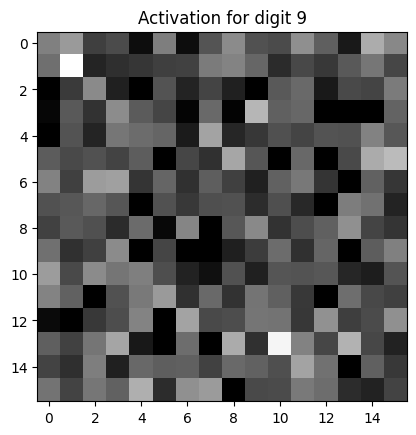

In [38]:
visualize_activations(model_Q2,test_loader,"Standard AE with hidden_layer=256",device,256)

## Q4

In [39]:
def add_noise(img, noise_val):
    noise = torch.randn(img.size())*noise_val
    noisy_img = img + noise
    return noisy_img

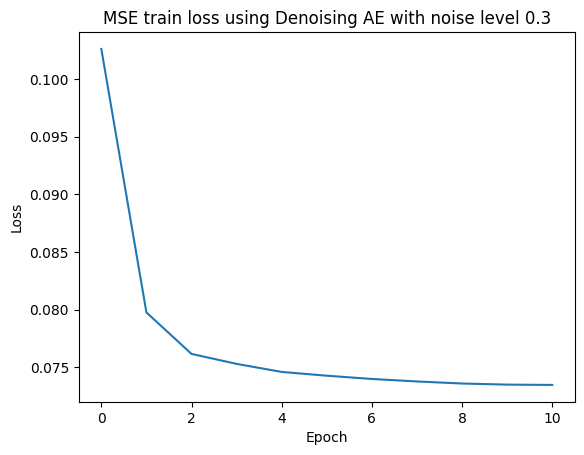

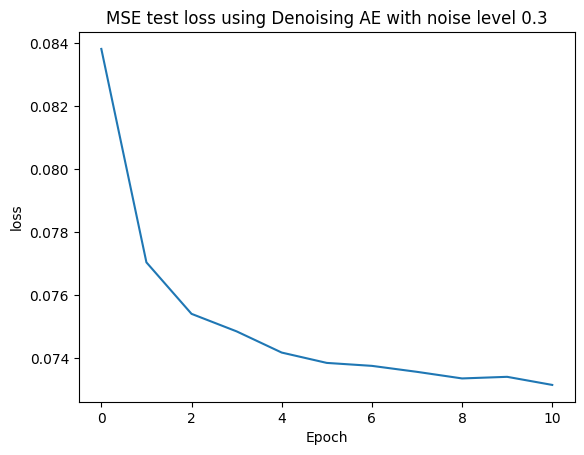

 MSE for the  0.3 = 0.0033181174658238888


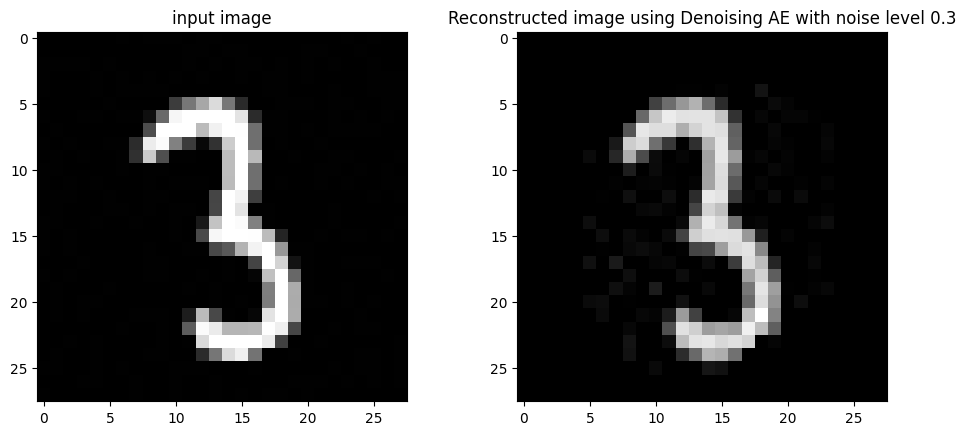

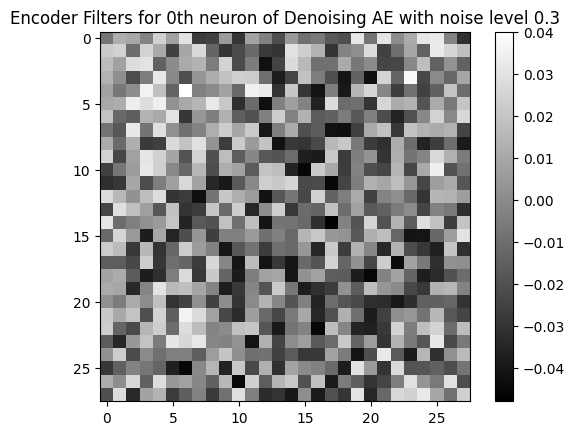

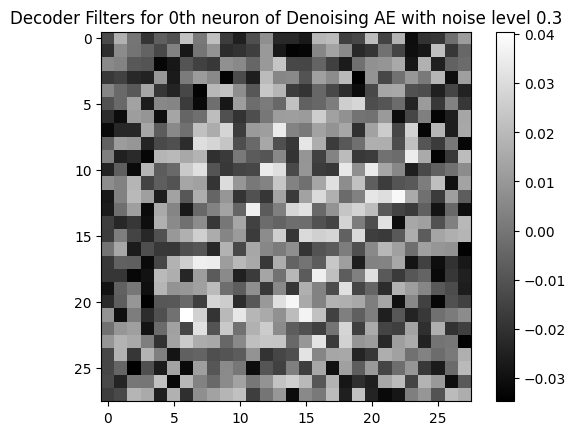

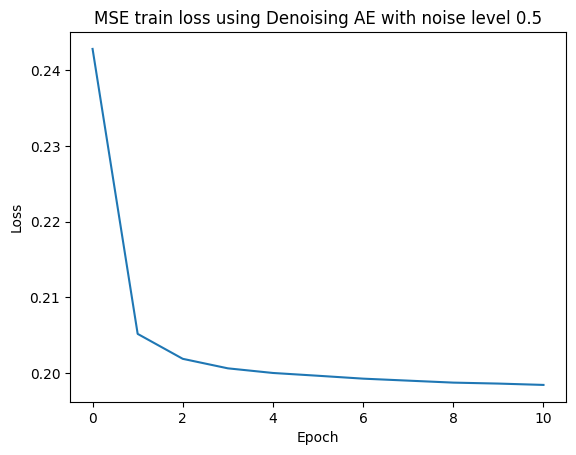

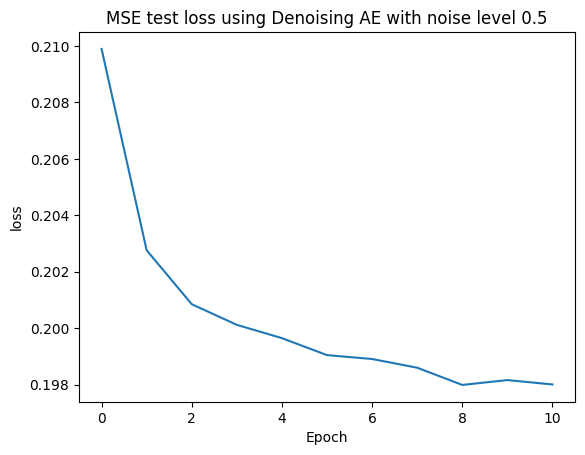

 MSE for the  0.5 = 0.0038982063997536898


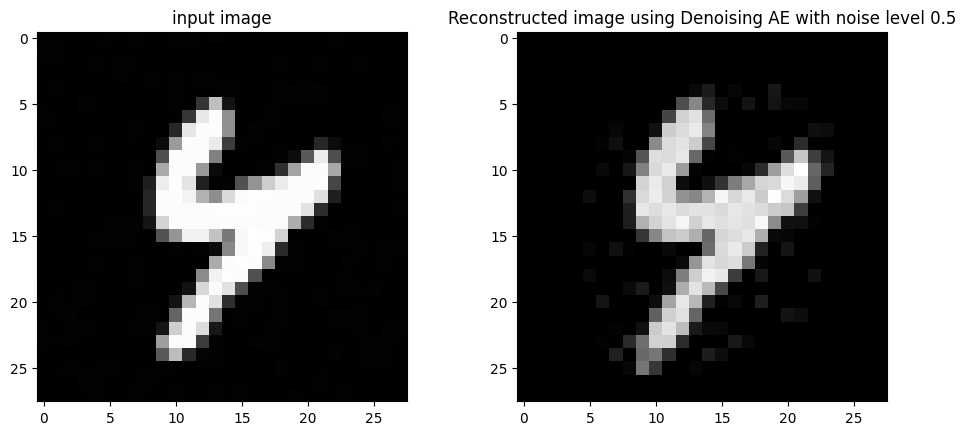

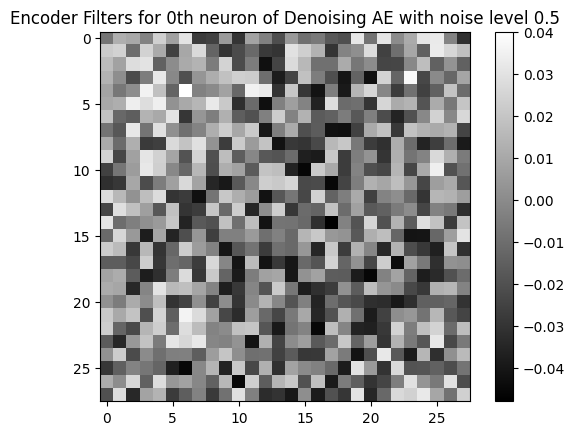

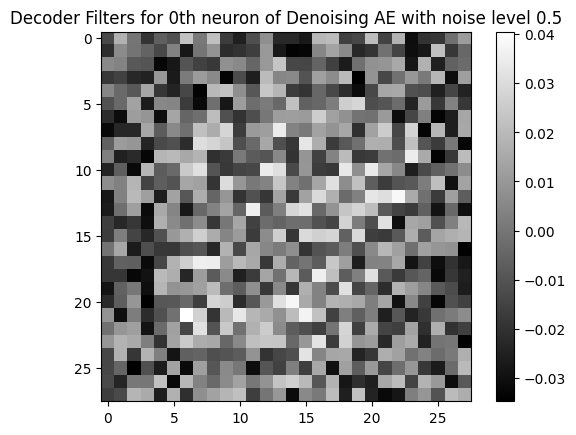

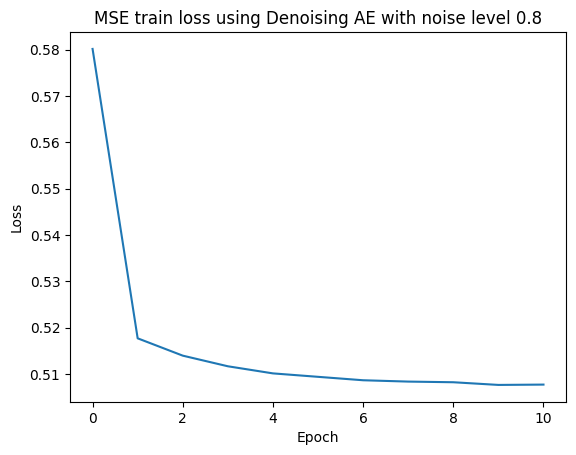

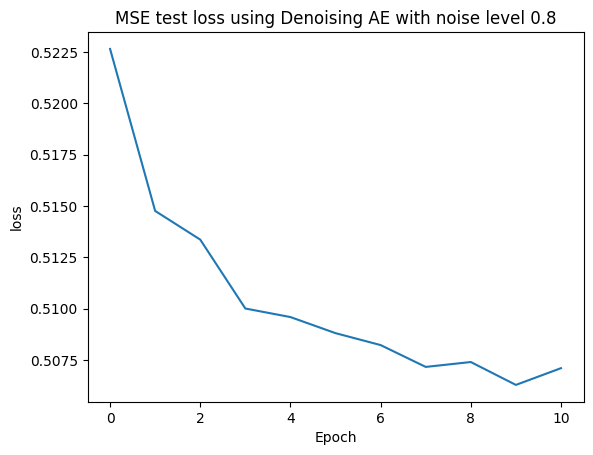

 MSE for the  0.8 = 0.006269432138651609


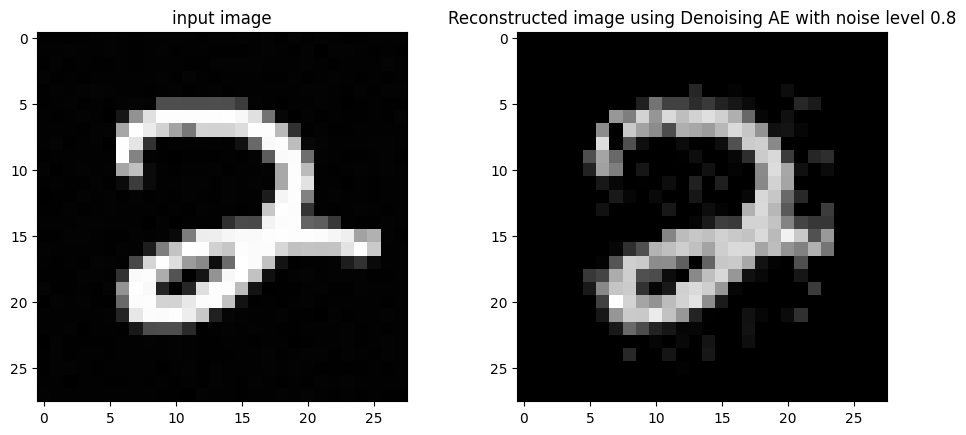

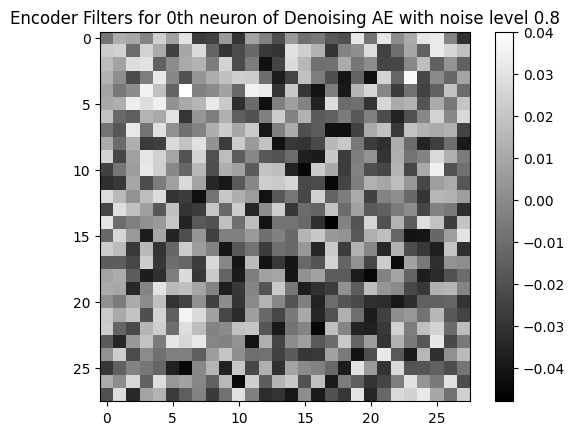

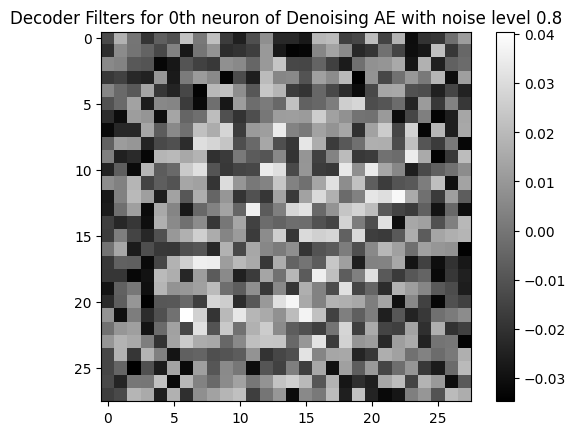

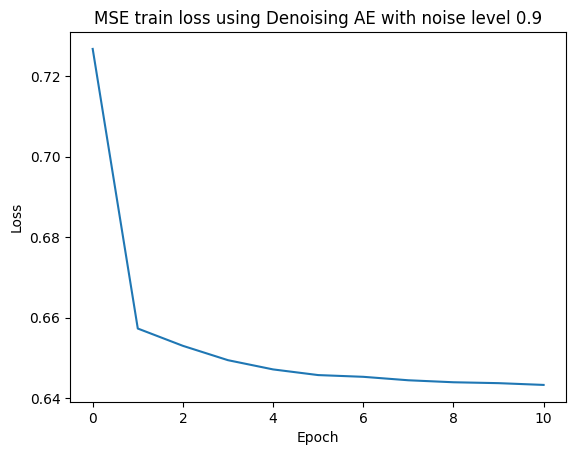

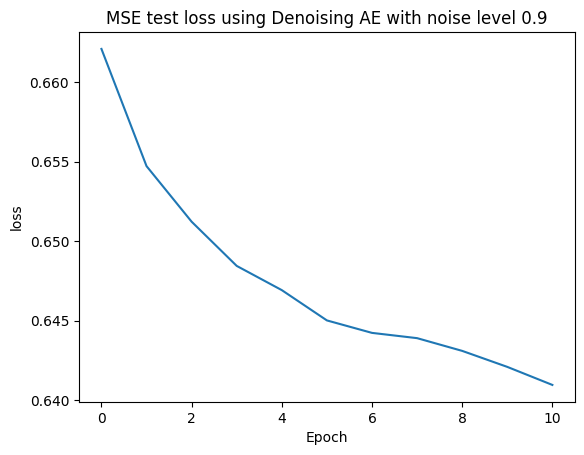

 MSE for the  0.9 = 0.006520132068544626


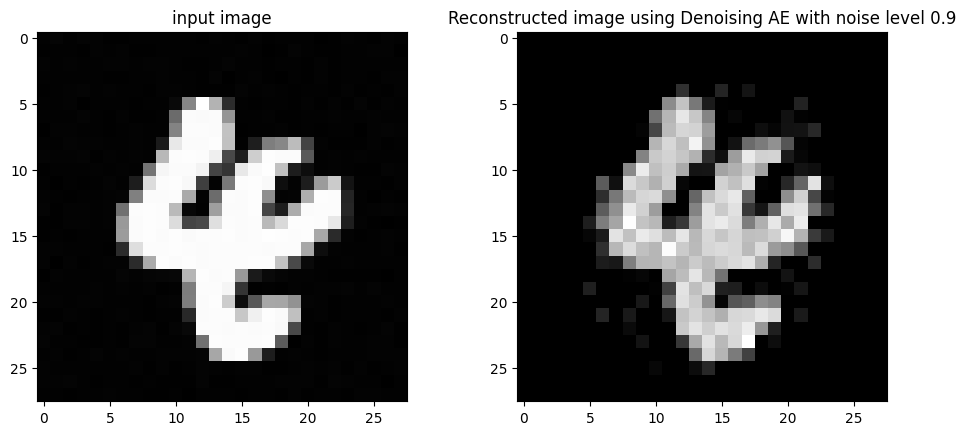

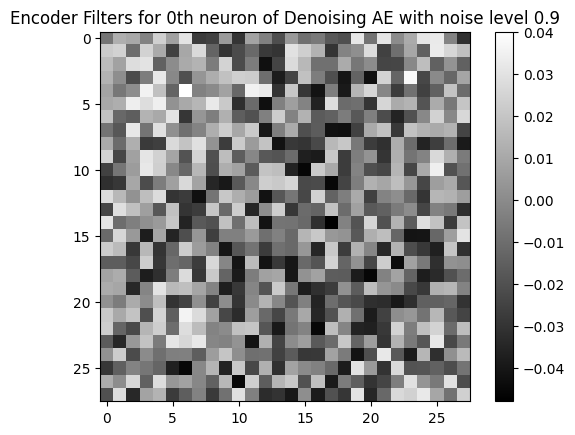

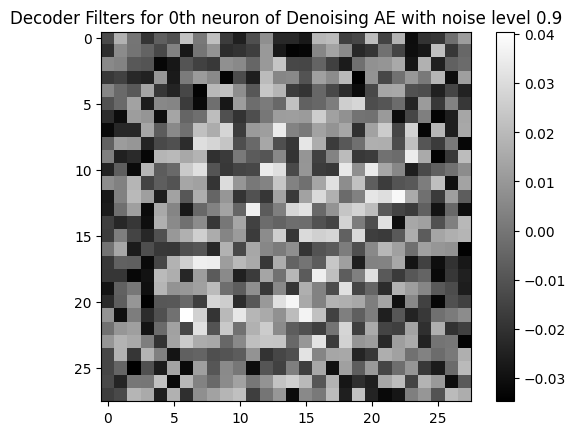

In [41]:
noise_vals = [0.3,0.5,0.8,0.9]
for noise_val in noise_vals:
    model_Q4 = AE_Q2(256).to(device)
    optimizer = torch.optim.Adam(model_Q4.parameters(), lr=learning_rate)
    train_losses_AE_Q4 , test_losses_AE_Q4 = train_test(model_Q4,device,train_loader,test_loader,optimizer,lossfn,denoise=True,noise_val=noise_val)
    plot_losses(train_losses_AE_Q4, test_losses_AE_Q4, model_name = "Denoising AE with noise level "+str(noise_val))
    #MSE recomnstruction error for vanilla AE
    mse_error = test(model_Q4,device,test_loader,lossfn)
    print(" MSE for the ",noise_val,"=", mse_error.item())
    index = random.randint(0,9999)
    test_image = test_loader.dataset.data[index, :, :].clone()
    test_image = add_noise(test_image,noise_val)
    plot_reconstructed_image(model_Q4,device,test_image, model_name="Denoising AE with noise level "+str(noise_val))
    encoder_decoder_filters_plots(model_Q3,"Denoising AE with noise level "+str(noise_val),device)


In [ ]:
# Convolutional Autoencoders

## Q5

In [42]:
class conv_AE_with_unpooling(nn.Module): #define unpooling outside the decoder and separately in forward nn.Sequential just takes one input
    
    def __init__(self): #class constructor
        super(conv_AE_with_unpooling,self).__init__() #calls the parent constructor
        
        #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        ) # 28x28x1 to 14x14x8
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        ) #14x14x8 to 7x7x16
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        ) #7x7x16 to 3x3x16
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.Identity()) #7x7x16 to 7x7x16
        self.decoder_conv2 = nn.Sequential(
            nn.Conv2d(16,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU()
        ) #14x14x16 to 14x14x8
        self.decoder_conv3 = nn.Sequential(
            nn.Conv2d(8,1, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU()
        ) #28x28x8 to 28x28x1
        
        #defining the unpooling operation
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())  # 28x28x1 to 14x14x8
        encoded_input,indices2  = self.encoder_conv2(encoded_input) #14x14x8 to 7x7x16
        encoded_input,indices3  = self.encoder_conv3(encoded_input) #7x7x16 to 3x3x16

        reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7])) #3x3x16 to 7x7x16
        reconstructed_input     = self.decoder_conv1(reconstructed_input) #7x7x16 to 7x7x16
        reconstructed_input     = self.unpool(reconstructed_input,indices2) #7x7x16 to 14x14x16
        reconstructed_input     = self.decoder_conv2(reconstructed_input)#14x14x16 to 14x14x8
        reconstructed_input     = self.unpool(reconstructed_input,indices1)#14x14x8 to 28x28x8
        reconstructed_input     = self.decoder_conv3(reconstructed_input)#28x28x8 to 28x28x1
        
        return reconstructed_input,encoded_input

In [43]:
from torchsummary import summary
print(conv_AE_with_unpooling().to(device))

conv_AE_with_unpooling(
  (encoder_conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_conv1): Sequential(
    (0): Identity()
  )
  (decoder_conv2): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv3): Sequential(
    (0): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (unpool): Max

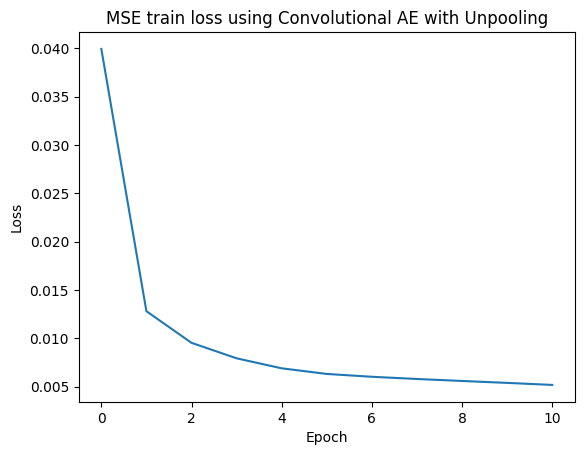

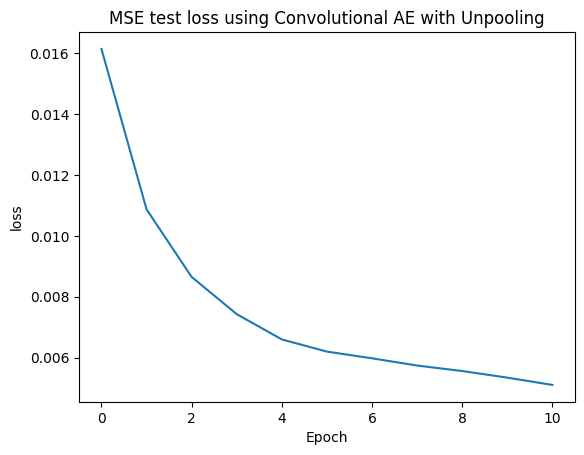

In [45]:
model_Q5_a = conv_AE_with_unpooling().to(device)
optimizer = torch.optim.Adam(model_Q5_a.parameters(), lr=learning_rate)
train_losses_AE_Q5_a , test_losses_AE_Q5_a = train_test(model_Q5_a,device,train_loader,test_loader,optimizer,lossfn,q5_flag=True)
plot_losses(train_losses_AE_Q5_a, test_losses_AE_Q5_a, model_name = "Convolutional AE with Unpooling")

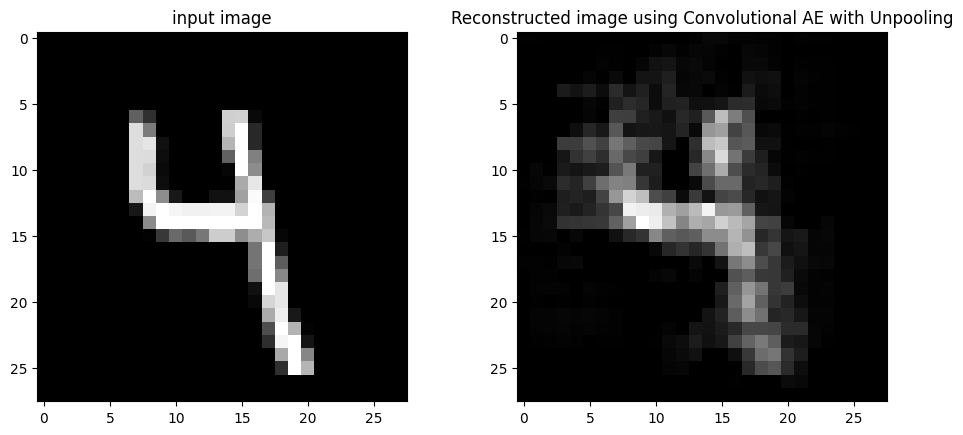

In [46]:
index = random.randint(0,9999)
test_image = test_loader.dataset.data[index, :, :].clone()
plot_reconstructed_image(model_Q5_a,device,test_image, model_name="Convolutional AE with Unpooling",q5_flag=True)

In [47]:
class conv_AE_with_deconv(nn.Module):
    def __init__(self):
        super(conv_AE_with_deconv,self).__init__() 
        
        #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        
        #decoder module
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),
            nn.ReLU()
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU()
        )
        
    def forward(self,x): 
        
        encoded_input  = self.encoder_conv1(x.float())
        encoded_input  = self.encoder_conv2(encoded_input)
        encoded_input  = self.encoder_conv3(encoded_input)

        reconstructed_input = self.decoder_conv1(encoded_input)
        reconstructed_input = self.decoder_conv2(reconstructed_input)
        reconstructed_input = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input

In [48]:
print(conv_AE_with_deconv().to(device))

conv_AE_with_deconv(
  (encoder_conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_conv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
  )
  (decoder_conv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv3): Sequential(
    (0): ConvTranspose2d(8, 1, kernel_

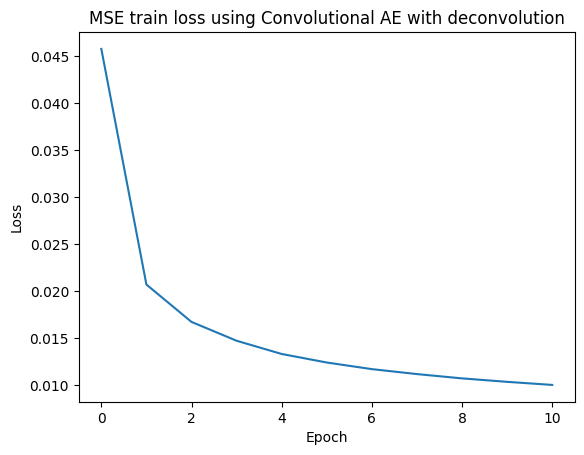

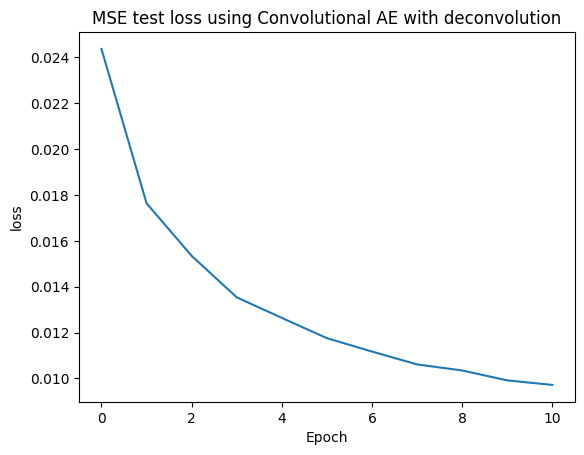

In [49]:
model_Q5_b = conv_AE_with_deconv().to(device)
optimizer = torch.optim.Adam(model_Q5_b.parameters(), lr=learning_rate)
train_losses_AE_Q5_b , test_losses_AE_Q5_b = train_test(model_Q5_b,device,train_loader,test_loader,optimizer,lossfn,q5_flag=True)
plot_losses(train_losses_AE_Q5_b, test_losses_AE_Q5_b, model_name = "Convolutional AE with deconvolution")

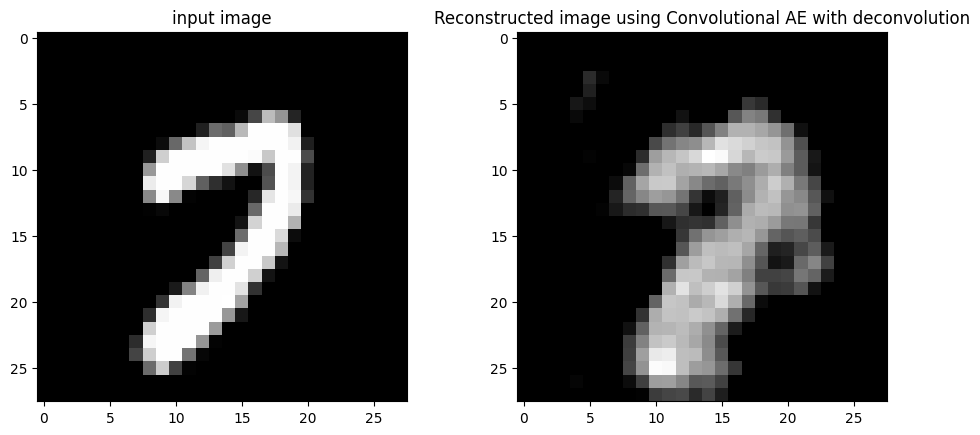

In [50]:
index = random.randint(0,9999)
test_image = test_loader.dataset.data[index, :, :].clone()
plot_reconstructed_image(model_Q5_b,device,test_image, model_name="Convolutional AE with deconvolution",q5_flag=True)

In [51]:
class conv_AE_with_deconv_unpool(nn.Module):
    def __init__(self): 
        super(conv_AE_with_deconv_unpool,self).__init__() 
        
         #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        
        #unpooling 
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())
        encoded_input,indices2  = self.encoder_conv2(encoded_input)
        encoded_input,indices3  = self.encoder_conv3(encoded_input)
    
        reconstructed_input = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7]))
        reconstructed_input = self.decoder_conv1(reconstructed_input)
        reconstructed_input = self.unpool(reconstructed_input,indices2)
        reconstructed_input = self.decoder_conv2(reconstructed_input)
        reconstructed_input = self.unpool(reconstructed_input,indices1)
        reconstructed_input = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input 

In [52]:
from torchsummary import summary
print(conv_AE_with_deconv_unpool().to(device))

conv_AE_with_deconv_unpool(
  (encoder_conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_conv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder_conv3): Sequential(
    (0): ConvTr

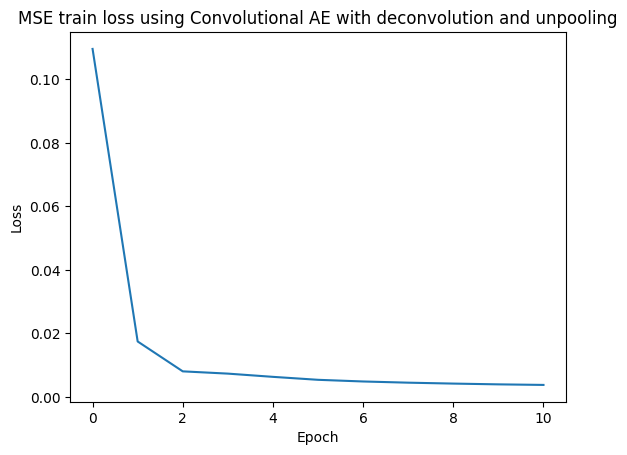

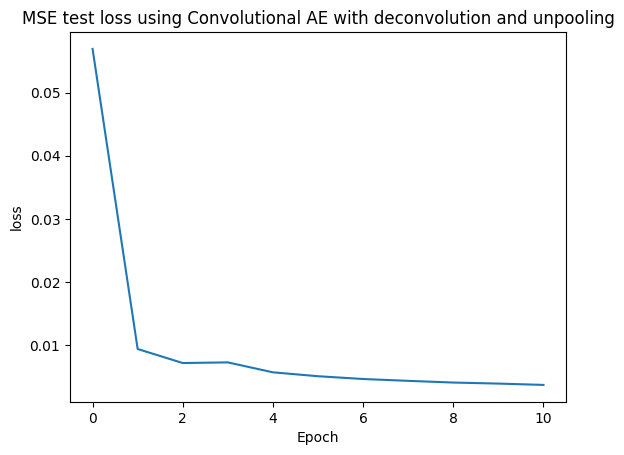

In [53]:
model_Q5_c = conv_AE_with_deconv_unpool().to(device)
optimizer = torch.optim.Adam(model_Q5_c.parameters(), lr=learning_rate)
train_losses_AE_Q5_c , test_losses_AE_Q5_c = train_test(model_Q5_c,device,train_loader,test_loader,optimizer,lossfn,q5_flag=True)
plot_losses(train_losses_AE_Q5_c, test_losses_AE_Q5_c, model_name = "Convolutional AE with deconvolution and unpooling")

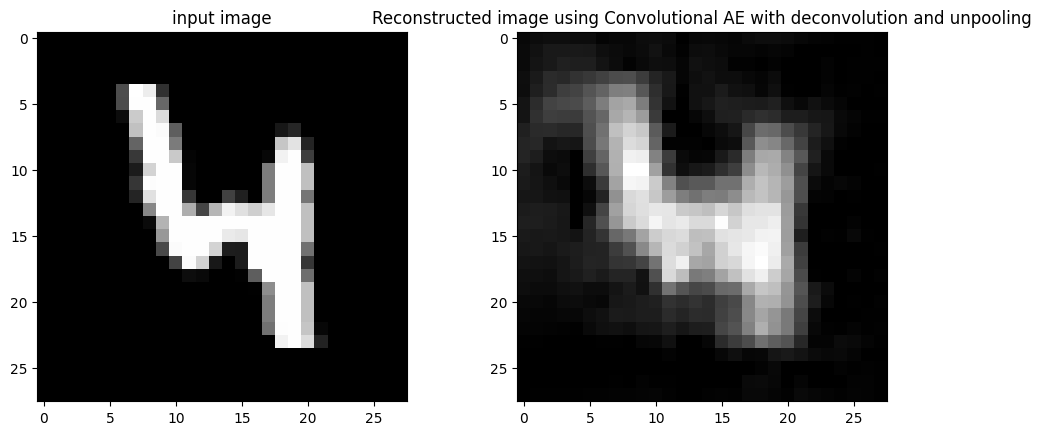

In [54]:
index = random.randint(0,9999)
test_image = test_loader.dataset.data[index, :, :].clone()
plot_reconstructed_image(model_Q5_c,device,test_image, model_name="Convolutional AE with deconvolution and unpooling",q5_flag=True)

In [55]:
from torchvision.utils import make_grid

In [56]:
def conv_AE_visualize_decoder_weights(model,model_name,device,decoder_conv_filter,decoder_layer):
    if(device == torch.device('cuda')):
        decoder_conv_filter = decoder_conv_filter.cpu()
    #normalize the filter weights
    decoder_conv_filter -= decoder_conv_filter.min()
    decoder_conv_filter /= decoder_conv_filter.max()
    (x,y,z,w) = decoder_conv_filter.size()
    filt_ind = np.random.randint(0 ,decoder_conv_filter.size()[0],3)
    for ind in filt_ind: 
        image = make_grid(decoder_conv_filter[ind].reshape(y,1,z,w)) 
        image = image.permute(1,2,0) 
        plt.imshow(image)
        plt.title("Decoder "+str(decoder_layer)+" Convolutional layer filter outputs for filter no. "+str(ind)+" of "+str(model_name))
        plt.show()

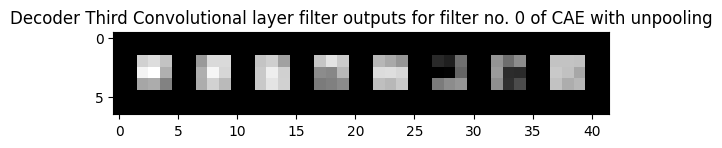

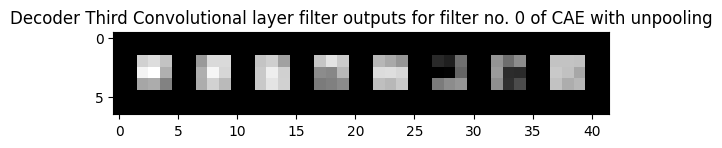

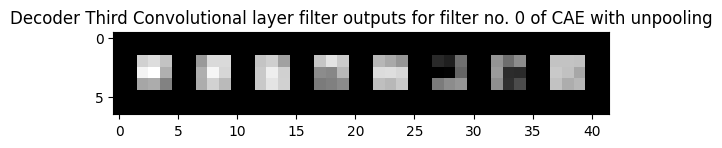

In [57]:
conv_3_filter = model_Q5_a.decoder_conv3[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_a,model_name="CAE with unpooling",device=device,decoder_conv_filter=conv_3_filter,decoder_layer="Third")

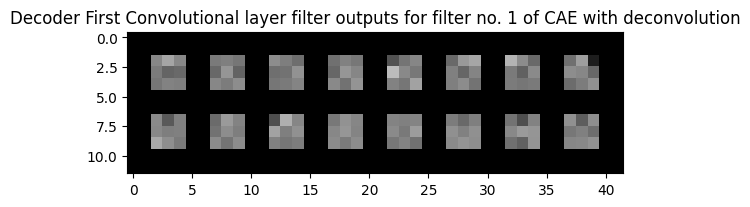

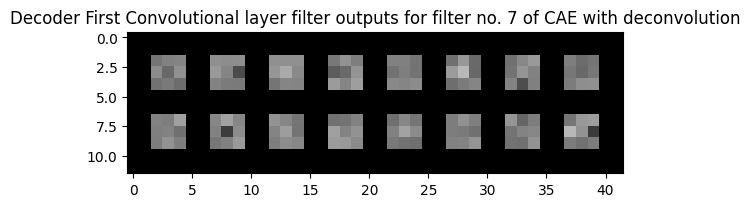

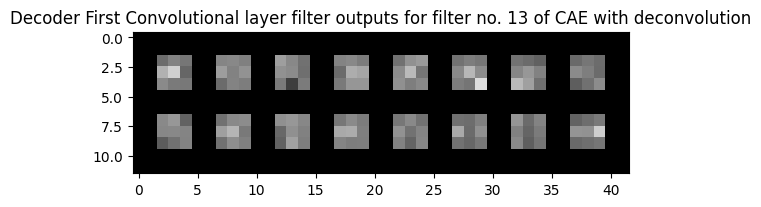

In [58]:
conv_1_filter = model_Q5_b.decoder_conv1[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_b,model_name="CAE with deconvolution",device=device,decoder_conv_filter=conv_1_filter,decoder_layer="First")

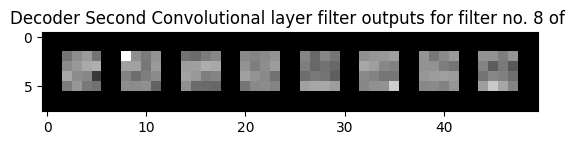

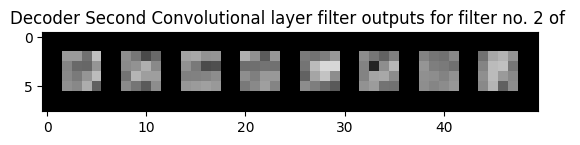

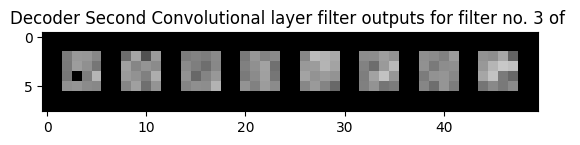

In [65]:
conv_2_filter = model_Q5_b.decoder_conv2[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_b,model_name="",device=device,decoder_conv_filter=conv_2_filter,decoder_layer="Second")

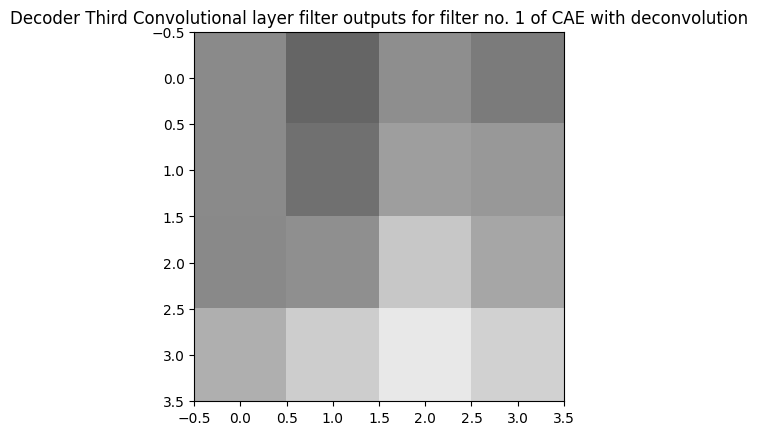

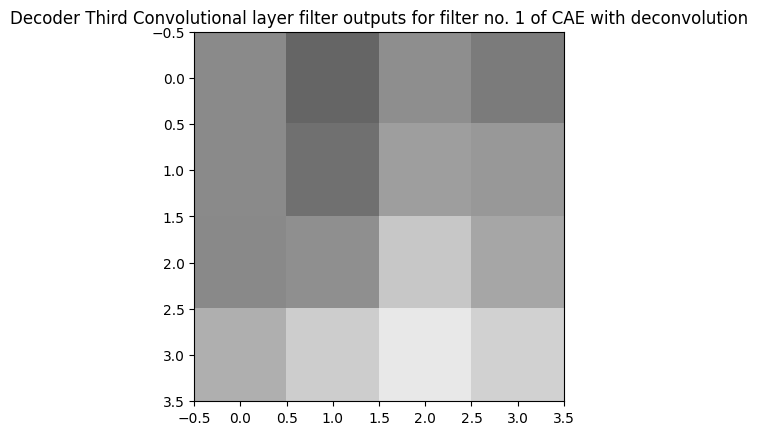

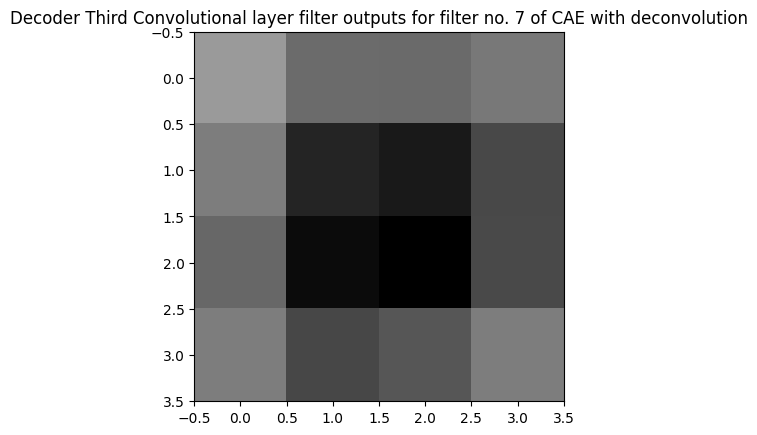

In [66]:
conv_3_filter = model_Q5_b.decoder_conv3[0].weight.detach().clone() 
conv_AE_visualize_decoder_weights(model=model_Q5_b,model_name="CAE with deconvolution",device=device,decoder_conv_filter=conv_3_filter,decoder_layer="Third")